## Predicting Default Credit Case Study

* **Business Context** - Banks are primarily known for money lending business. The more money they lend to people whom they can get good interest with timely repayment, the more revenue is for the banks.
* **
* The more banks are able to identify borrowers going towards serious delinquency rate, the better will be the bank's money lending business which in turn will lead to better revenue and better image in the market and with respect to competitiors. 
* **
* * **Delinquent** in general is a slightly mild term where a borrower is not repaying charges and is behind by certain months whereas * **Default** is a term where a borrower has not been able to pay charges and is behind for a long period of months and is unlikely to repay the charges.
* **
* We have a general profile about the borrower such as age, Monthly Income, Dependents and the historical data such as what is the Debt Ratio, what ratio of amount is owed wrt credit limit, and the no of times defaulted in the past one, two, three months.
* We will be using all these features to predict whether the borrower is likely to delinquent in the next 2 years or not.
* These kind of predictions will help banks to take necessary actions.


In [2]:
#* **Objective** : Building a model using the inputs/attributes which are general profile and historical records of a borrower to predict whether one is likely to have serious delinquency in the next 2 years 

In [3]:
# !pip install pandas==1.3.0
# !pip install numpy==1.18.5
# !pip install imbalanced_learn==0.8.0
# !pip install scipy==1.7.0
# !pip install lightgbm==3.3.0
# !pip install imblearn==0.0
# !pip install scikit_learn==1.0.2
# !pip install lime==0.2.0.1
# !pip install shap==0.40.0

In [5]:
from zipfile import ZipFile
import urllib.request
from io import BytesIO

folder = urllib.request.urlopen('https://s3.amazonaws.com/hackerday.datascience/15/new/Data.zip')
zipfile = ZipFile(BytesIO(folder.read()))
zipfile.namelist()

['cs-test.csv',
 '__MACOSX/._cs-test.csv',
 'cs-training.csv',
 '__MACOSX/._cs-training.csv']

* **Importing libraries**

In [6]:
# Importing required libraries
import pandas as pd
import numpy as np
import math
from scipy.stats import kurtosis
from scipy import stats, special
from scipy.stats import skew
import shap
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot

In [7]:
# Ignore all warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore')

In [8]:
# Display all rows and columns of a dataframe
pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 1000)

In [9]:
# Importing ML algorithms
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.metrics import mean_squared_error, accuracy_score,confusion_matrix, roc_curve, auc,classification_report, recall_score, precision_score, f1_score,roc_auc_score,auc,roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [10]:
import tensorflow as tf
import keras
import keras.backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import models
from keras import layers

* ** Showing dataset**

In [11]:
# Reading the training dataset
df = pd.read_csv(zipfile.open('cs-training.csv'))

In [12]:
# No of rows and the columns
df.shape

(150000, 12)

In [13]:
# A general information about the datatype of an attribute and missing values(if any)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

In [14]:
# what percentage of data is missing in the feature
round(df.isnull().sum(axis=0)/len(df),2)*100

Unnamed: 0                               0.0
SeriousDlqin2yrs                         0.0
RevolvingUtilizationOfUnsecuredLines     0.0
age                                      0.0
NumberOfTime30-59DaysPastDueNotWorse     0.0
DebtRatio                                0.0
MonthlyIncome                           20.0
NumberOfOpenCreditLinesAndLoans          0.0
NumberOfTimes90DaysLate                  0.0
NumberRealEstateLoansOrLines             0.0
NumberOfTime60-89DaysPastDueNotWorse     0.0
NumberOfDependents                       3.0
dtype: float64

In [15]:
df.head()

Unnamed: 0  SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
0           1                 1                              0.766127   45   
1           2                 0                              0.957151   40   
2           3                 0                              0.658180   38   
3           4                 0                              0.233810   30   
4           5                 0                              0.907239   49   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
0                                     2   0.802982         9120.0   
1                                     0   0.121876         2600.0   
2                                     1   0.085113         3042.0   
3                                     0   0.036050         3300.0   
4                                     1   0.024926        63588.0   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
0                               13                        0   
1                                4                        0   
2                                2                        1   
3                                5                        0   
4                                7                        0   

   NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
0                             6                                     0   
1                             0                                     0   
2                             0                                     0   
3                             0                                     0   
4                             1                                     0   

   NumberOfDependents  
0                 2.0  
1                 1.0  
2                 0.0  
3                 0.0  
4                 0.0

In [16]:
# Checking the unique number of borrowers
df['Unnamed: 0'].nunique()/len(df)

1.0

In [17]:
df.rename(columns = {'Unnamed: 0' : 'CustomerID'},inplace=True)

In [18]:
# Target Variable
print(df['SeriousDlqin2yrs'].unique())
print()
print('{}% of the borrowers falling in the serious delinquency '.format((df['SeriousDlqin2yrs'].sum()/len(df))*100))

[1 0]

6.683999999999999% of the borrowers falling in the serious delinquency 


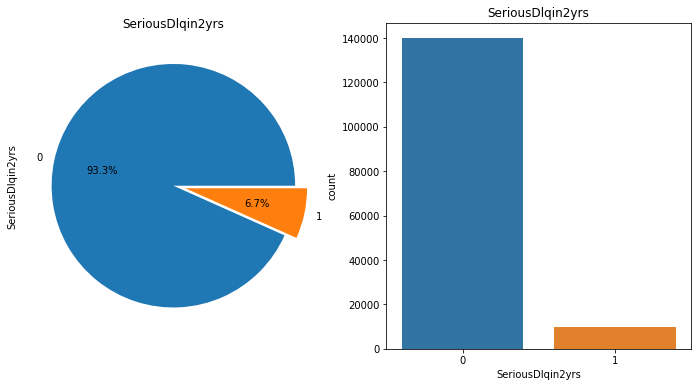

In [19]:
fig, axes = plt.subplots(1,2,figsize=(12,6))
df['SeriousDlqin2yrs'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=axes[0])
axes[0].set_title('SeriousDlqin2yrs')
sns.countplot('SeriousDlqin2yrs',data=df,ax=axes[1])
axes[1].set_title('SeriousDlqin2yrs')
plt.show()

In [20]:
df['SeriousDlqin2yrs'].value_counts()

0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64

In [21]:
df.describe()

CustomerID  SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  \
count  150000.000000     150000.000000                         150000.000000   
mean    75000.500000          0.066840                              6.048438   
std     43301.414527          0.249746                            249.755371   
min         1.000000          0.000000                              0.000000   
25%     37500.750000          0.000000                              0.029867   
50%     75000.500000          0.000000                              0.154181   
75%    112500.250000          0.000000                              0.559046   
max    150000.000000          1.000000                          50708.000000   

                 age  NumberOfTime30-59DaysPastDueNotWorse      DebtRatio  \
count  150000.000000                         150000.000000  150000.000000   
mean       52.295207                              0.421033     353.005076   
std        14.771866                              4.192781    2037.818523   
min         0.000000                              0.000000       0.000000   
25%        41.000000                              0.000000       0.175074   
50%        52.000000                              0.000000       0.366508   
75%        63.000000                              0.000000       0.868254   
max       109.000000                             98.000000  329664.000000   

       MonthlyIncome  NumberOfOpenCreditLinesAndLoans  \
count   1.202690e+05                    150000.000000   
mean    6.670221e+03                         8.452760   
std     1.438467e+04                         5.145951   
min     0.000000e+00                         0.000000   
25%     3.400000e+03                         5.000000   
50%     5.400000e+03                         8.000000   
75%     8.249000e+03                        11.000000   
max     3.008750e+06                        58.000000   

       NumberOfTimes90DaysLate  NumberRealEstateLoansOrLines  \
count            150000.000000                 150000.000000   
mean                  0.265973                      1.018240   
std                   4.169304                      1.129771   
min                   0.000000                      0.000000   
25%                   0.000000                      0.000000   
50%                   0.000000                      1.000000   
75%                   0.000000                      2.000000   
max                  98.000000                     54.000000   

       NumberOfTime60-89DaysPastDueNotWorse  NumberOfDependents  
count                         150000.000000       146076.000000  
mean                               0.240387            0.757222  
std                                4.155179            1.115086  
min                                0.000000            0.000000  
25%                                0.000000            0.000000  
50%                                0.000000            0.000000  
75%                                0.000000            1.000000  
max                               98.000000           20.000000

### Separating the dataset into train-test split

* **We will split the dataset into training(80%) on which modeling will be done using statistical/machine learning technqiues**
* **
* **Another one is the test dataset(20%) on which predictions will be made and check how the model is performing**

In [22]:
data = df.drop(columns = ['SeriousDlqin2yrs'], axis=1)

In [23]:
y = df['SeriousDlqin2yrs']

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
# Splitting the dataset into train and test validation
df_test, df_train, y_test, y_train = train_test_split(data, y, test_size = 0.8, random_state=42, stratify = y)
df_test.shape, df_train.shape

((30000, 11), (120000, 11))

In [26]:
print('Event rate in the training dataset : ',np.mean(y_train))
print()
print('Event rate in the test dataset : ',np.mean(y_test))
print()
print('Event rate in the entire dataset : ',np.mean(y))

Event rate in the training dataset :  0.06684166666666666

Event rate in the test dataset :  0.06683333333333333

Event rate in the entire dataset :  0.06684


* Event rate/Default Rate is maintainted in the training and test dataset after splitting in line with the entire dataset

In [27]:
train = pd.concat([df_train, y_train], axis=1)
train.shape

(120000, 12)

In [28]:
test = pd.concat([df_test, y_test], axis=1)
test.shape

(30000, 12)

### Univariate Analysis using Training Numerical dataset

In [29]:
def plot_hist_boxplot(column):
    fig,[ax1,ax2]=plt.subplots(1,2,figsize=(12,5))
    sns.distplot(train[train[column].notnull()][column],ax=ax1)
    sns.boxplot(y=train[train[column].notnull()][column],ax=ax2)
    print("skewness : ",skew(train[train[column].notnull()][column]))
    print("kurtosis : ",kurtosis(train[train[column].notnull()][column]))
    plt.show()

In [30]:
def plot_count_boxplot(column):
    fig,[ax1,ax2]=plt.subplots(1,2,figsize=(12,6))
    sns.countplot(train[train[column].notnull()][column],ax=ax1)
    sns.boxplot(y=train[train[column].notnull()][column],ax=ax2)
    print("skewness : ",skew(train[train[column].notnull()][column]))
    print("kurtosis : ",kurtosis(train[train[column].notnull()][column]))
    plt.show()

skewness :  104.51383625945637
kurtosis :  16544.639125909292


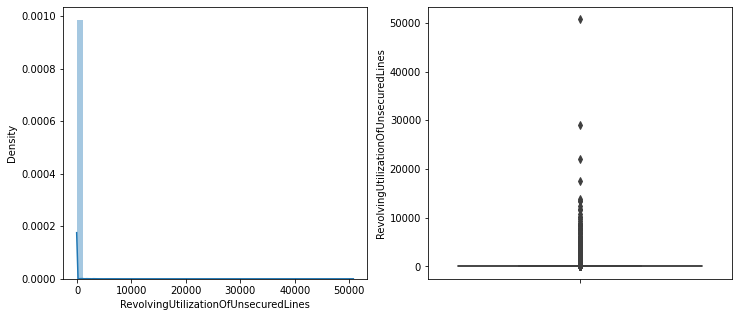

In [31]:
plot_hist_boxplot('RevolvingUtilizationOfUnsecuredLines')

skewness :  0.1883379862757487
kurtosis :  -0.4989842553901078


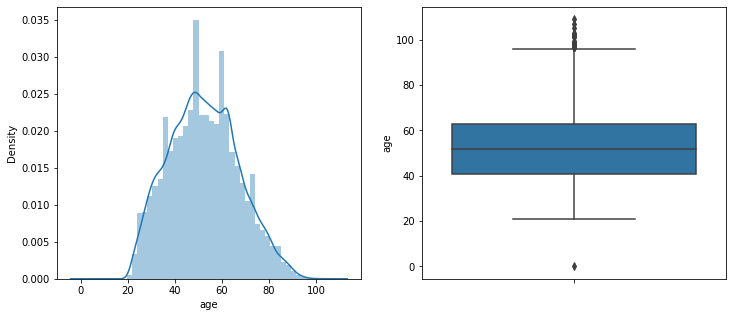

In [32]:
plot_hist_boxplot('age')

skewness :  95.78845308753385
kurtosis :  14212.893907176613


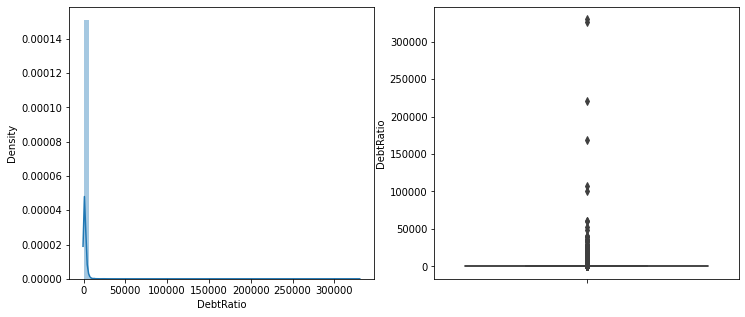

In [33]:
plot_hist_boxplot('DebtRatio')

skewness :  117.98020100894865
kurtosis :  19658.712451467025


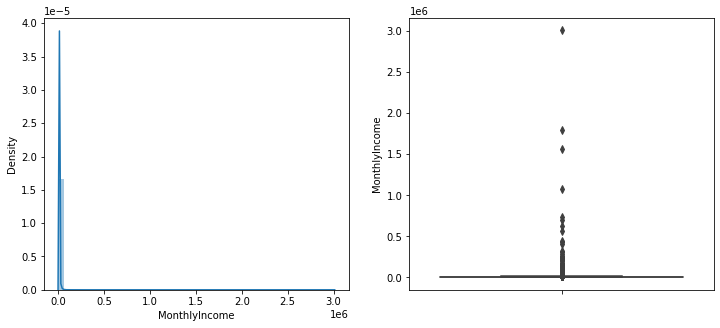

In [34]:
plot_hist_boxplot('MonthlyIncome')

skewness :  1.2145901173605567
kurtosis :  3.114685912968633


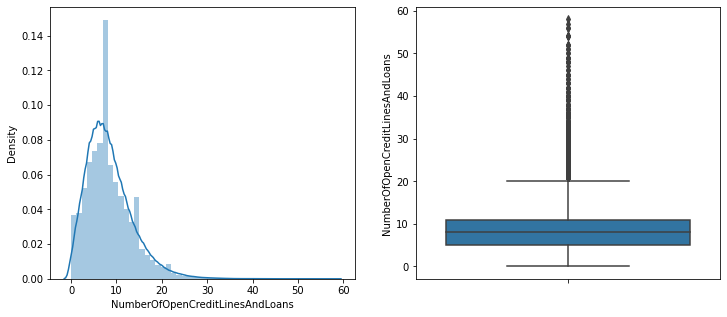

In [35]:
plot_hist_boxplot('NumberOfOpenCreditLinesAndLoans')

skewness :  3.635466187390173
kurtosis :  67.79380246787325


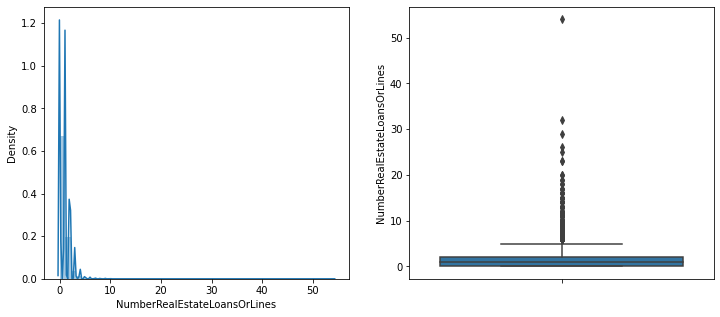

In [36]:
plot_hist_boxplot('NumberRealEstateLoansOrLines')

skewness :  1.5991497659767622
kurtosis :  3.1681417562669285


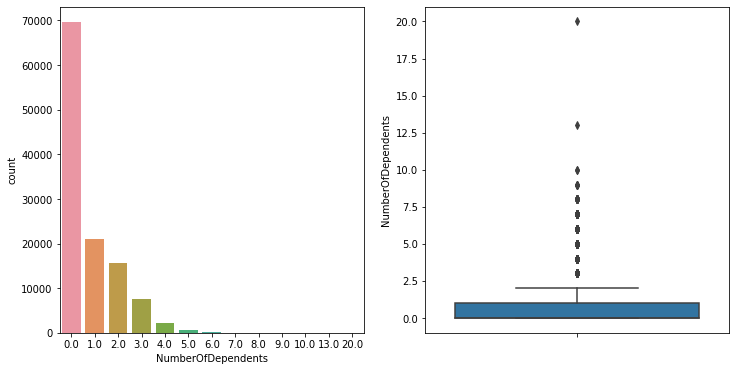

In [37]:
plot_count_boxplot('NumberOfDependents')

skewness :  22.56005009391927
kurtosis :  520.5861400129826


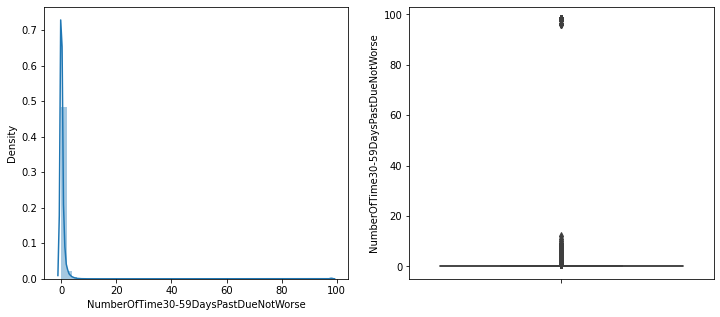

In [38]:
plot_hist_boxplot('NumberOfTime30-59DaysPastDueNotWorse')

skewness :  23.287569502079286
kurtosis :  543.6121286456557


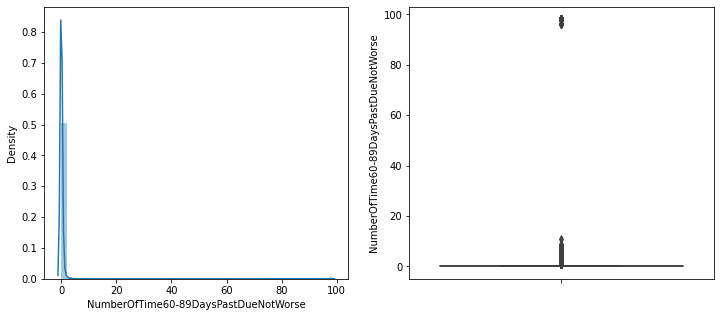

In [39]:
plot_hist_boxplot('NumberOfTime60-89DaysPastDueNotWorse')

skewness :  23.0371547196054
kurtosis :  535.4918343524778


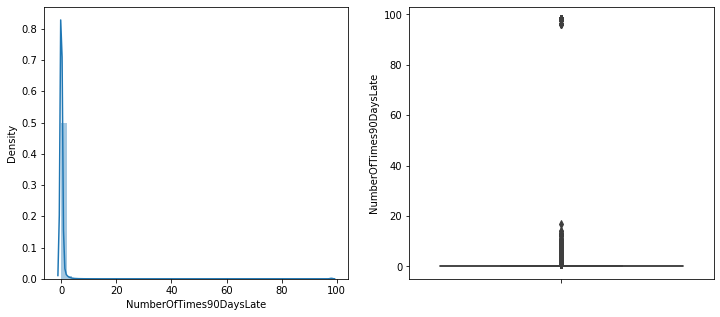

In [40]:
plot_hist_boxplot('NumberOfTimes90DaysLate')

In [41]:
cols_for_stats = ['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents']

In [42]:
skewness  = [] ; kurt = []
for column in cols_for_stats:
    skewness.append(skew(train[train[column].notnull()][column]))
    kurt.append(kurtosis(train[train[column].notnull()][column]))
    
stats = pd.DataFrame({'Skewness' : skewness, 'Kurtosis' : kurt},index=[col for col in cols_for_stats])
stats.sort_values(by=['Skewness'], ascending=False)

Skewness      Kurtosis
MonthlyIncome                         117.980201  19658.712451
RevolvingUtilizationOfUnsecuredLines  104.513836  16544.639126
DebtRatio                              95.788453  14212.893907
NumberOfTime60-89DaysPastDueNotWorse   23.287570    543.612129
NumberOfTimes90DaysLate                23.037155    535.491834
NumberOfTime30-59DaysPastDueNotWorse   22.560050    520.586140
NumberRealEstateLoansOrLines            3.635466     67.793802
NumberOfDependents                      1.599150      3.168142
NumberOfOpenCreditLinesAndLoans         1.214590      3.114686
age                                     0.188338     -0.498984

* * Data distribution in the columns are highly right skewed with very high kurtosis value showing extreme outliers in those columns
* * Except age which is little normally distributed

### Data Cleaning

#### Outlier Treatement

* *From the above boxplot graphs we can observe:*
* **
* *In the columns NumberOfTime30-59DaysPastDueNotWorse , NumberOfTime60-89DaysPastDueNotWorse and NumberOfTimes90DaysLate, we see delinquency range beyond 90 which is common across all 3 features.*
* **
* *Treating outliers for the columns  -- NumberOfTime30-59DaysPastDueNotWorse , NumberOfTime60-89DaysPastDueNotWorse and NumberOfTimes90DaysLate*

In [43]:
print("Unique values in '30-59 Days' values that are more than or equal to 90:",np.unique(train[train['NumberOfTime30-59DaysPastDueNotWorse']>=90]
                                                                                          ['NumberOfTime30-59DaysPastDueNotWorse']))


print("Unique values in '60-89 Days' when '30-59 Days' values are more than or equal to 90:",np.unique(train[train['NumberOfTime30-59DaysPastDueNotWorse']>=90]
                                                                                                       ['NumberOfTime60-89DaysPastDueNotWorse']))


print("Unique values in '90 Days' when '30-59 Days' values are more than or equal to 90:",np.unique(train[train['NumberOfTime30-59DaysPastDueNotWorse']>=90]
                                                                                                    ['NumberOfTimes90DaysLate']))


print("Unique values in '30-59 Days' values that are less than 90:",np.unique(train[train['NumberOfTime30-59DaysPastDueNotWorse']<90]
                                                                                          ['NumberOfTime30-59DaysPastDueNotWorse']))


print("Unique values in '60-89 Days' when '30-59 Days' values are less than 90:",np.unique(train[train['NumberOfTime30-59DaysPastDueNotWorse']<90]
                                                                                           ['NumberOfTime60-89DaysPastDueNotWorse']))


print("Unique values in '90 Days' when '30-59 Days' values are less than 90:",np.unique(train[train['NumberOfTime30-59DaysPastDueNotWorse']<90]
                                                                                        ['NumberOfTimes90DaysLate']))


print("Proportion of positive class with special 96/98 values:",
      round(train[train['NumberOfTime30-59DaysPastDueNotWorse']>=90]['SeriousDlqin2yrs'].sum()*100/
      len(train[train['NumberOfTime30-59DaysPastDueNotWorse']>=90]['SeriousDlqin2yrs']),2),'%')

Unique values in '30-59 Days' values that are more than or equal to 90: [96 98]
Unique values in '60-89 Days' when '30-59 Days' values are more than or equal to 90: [96 98]
Unique values in '90 Days' when '30-59 Days' values are more than or equal to 90: [96 98]
Unique values in '30-59 Days' values that are less than 90: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Unique values in '60-89 Days' when '30-59 Days' values are less than 90: [ 0  1  2  3  4  5  6  7  8  9 11]
Unique values in '90 Days' when '30-59 Days' values are less than 90: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 17]
Proportion of positive class with special 96/98 values: 55.56 %


* *We can see from the following that when records in column 'NumberOfTime30-59DaysPastDueNotWorse' are more than 90, the other columns that records number of times payments are past due X days also have the same values. We will classify these as special labels since the proportion of positive class is abnormally high at 55.56%.*
* **
* *These 96 and 98 values can be viewed as accounting errors. Hence, we would replace them with the maximum value before 96 i.e. 12, 11 and 17*

In [44]:
train.loc[train['NumberOfTime30-59DaysPastDueNotWorse'] >= 90, 'NumberOfTime30-59DaysPastDueNotWorse'] = 12
train.loc[train['NumberOfTime60-89DaysPastDueNotWorse'] >= 90, 'NumberOfTime60-89DaysPastDueNotWorse'] = 11
train.loc[train['NumberOfTimes90DaysLate'] >= 90, 'NumberOfTimes90DaysLate'] = 17

In [45]:
print("Unique values in 30-59Days", np.unique(train['NumberOfTime30-59DaysPastDueNotWorse']))
print("Unique values in 60-89Days", np.unique(train['NumberOfTime60-89DaysPastDueNotWorse']))
print("Unique values in 90Days", np.unique(train['NumberOfTimes90DaysLate']))

Unique values in 30-59Days [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Unique values in 60-89Days [ 0  1  2  3  4  5  6  7  8  9 11]
Unique values in 90Days [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 17]


In [46]:
print("Unique values in '30-59 Days' values that are more than or equal to 90:",np.unique(test[test['NumberOfTime30-59DaysPastDueNotWorse']>=90]
                                                                                          ['NumberOfTime30-59DaysPastDueNotWorse']))


print("Unique values in '60-89 Days' when '30-59 Days' values are more than or equal to 90:",np.unique(test[test['NumberOfTime30-59DaysPastDueNotWorse']>=90]
                                                                                                       ['NumberOfTime60-89DaysPastDueNotWorse']))


print("Unique values in '90 Days' when '30-59 Days' values are more than or equal to 90:",np.unique(test[test['NumberOfTime30-59DaysPastDueNotWorse']>=90]
                                                                                                    ['NumberOfTimes90DaysLate']))


print("Unique values in '30-59 Days' values that are less than 90:",np.unique(test[test['NumberOfTime30-59DaysPastDueNotWorse']<90]
                                                                                          ['NumberOfTime30-59DaysPastDueNotWorse']))


print("Unique values in '60-89 Days' when '30-59 Days' values are less than 90:",np.unique(test[test['NumberOfTime30-59DaysPastDueNotWorse']<90]
                                                                                           ['NumberOfTime60-89DaysPastDueNotWorse']))


print("Unique values in '90 Days' when '30-59 Days' values are less than 90:",np.unique(test[test['NumberOfTime30-59DaysPastDueNotWorse']<90]
                                                                                        ['NumberOfTimes90DaysLate']))


Unique values in '30-59 Days' values that are more than or equal to 90: [98]
Unique values in '60-89 Days' when '30-59 Days' values are more than or equal to 90: [98]
Unique values in '90 Days' when '30-59 Days' values are more than or equal to 90: [98]
Unique values in '30-59 Days' values that are less than 90: [ 0  1  2  3  4  5  6  7  8  9 10 12 13]
Unique values in '60-89 Days' when '30-59 Days' values are less than 90: [0 1 2 3 4 5 6 7]
Unique values in '90 Days' when '30-59 Days' values are less than 90: [ 0  1  2  3  4  5  6  7  8  9 10 11 15]


* *Since, these values exist in Test Set as well. Therefore, replacing them with maximum values before 96 and 98 i.e. 13, 7 and 15.*

In [47]:
test.loc[test['NumberOfTime30-59DaysPastDueNotWorse'] >= 90, 'NumberOfTime30-59DaysPastDueNotWorse'] = 13
test.loc[test['NumberOfTime60-89DaysPastDueNotWorse'] >= 90, 'NumberOfTime60-89DaysPastDueNotWorse'] = 7
test.loc[test['NumberOfTimes90DaysLate'] >= 90, 'NumberOfTimes90DaysLate'] = 15
print("Unique values in 30-59Days", np.unique(test['NumberOfTime30-59DaysPastDueNotWorse']))
print("Unique values in 60-89Days", np.unique(test['NumberOfTime60-89DaysPastDueNotWorse']))
print("Unique values in 90Days", np.unique(test['NumberOfTimes90DaysLate']))

Unique values in 30-59Days [ 0  1  2  3  4  5  6  7  8  9 10 12 13]
Unique values in 60-89Days [0 1 2 3 4 5 6 7]
Unique values in 90Days [ 0  1  2  3  4  5  6  7  8  9 10 11 15]


 * *Checking for * **DebtRatio** and * **RevolvingUtilizationOfUnsecuredLines.***

In [48]:
print('Debt Ratio: \n',train['DebtRatio'].describe())
print('\nRevolving Utilization of Unsecured Lines: \n',train['RevolvingUtilizationOfUnsecuredLines'].describe())

Debt Ratio: 
 count    120000.000000
mean        350.913763
std        1985.649364
min           0.000000
25%           0.174335
50%           0.365643
75%           0.866853
max      329664.000000
Name: DebtRatio, dtype: float64

Revolving Utilization of Unsecured Lines: 
 count    120000.000000
mean          5.986096
std         251.444207
min           0.000000
25%           0.029737
50%           0.154659
75%           0.559328
max       50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64


* **Debt Ratio**

* As you can see data is right skewed. So, our main aim would be to check the potential outliers beyond 95% quantiles. However, since our data is 120,000, let's consider 95% and 97.5% quantiles for our further analysis.

In [49]:
train[train['DebtRatio'] >= train['DebtRatio'].quantile(0.95)][['SeriousDlqin2yrs','MonthlyIncome']].describe()

SeriousDlqin2yrs  MonthlyIncome
count       6002.000000     308.000000
mean           0.054315       0.077922
std            0.226658       0.268485
min            0.000000       0.000000
25%            0.000000       0.000000
50%            0.000000       0.000000
75%            0.000000       0.000000
max            1.000000       1.000000

* Here we can observe:
* **
* Out of 6002 customers falling in the last 5 percentile of the data i.e. the number of times their debt is higher than their income, only 308 have Monthly Income values.
* The Max for Monthly Income is 1 and Min is 0 which makes us wonder that are data entry errors. Let's check whether the Serious Delinquency in 2 years and Monthly Income values are equal.

In [50]:
train[(train["DebtRatio"] > train["DebtRatio"].quantile(0.95)) & (train['SeriousDlqin2yrs'] == train['MonthlyIncome'])].shape[0]

271

* Hence, our suspects are true and there are 271 out of 308 rows where Monthly Income is equal to the Serious Delinquencies in 2 years. Hence we will remove these 271 outliers from our analysis as their current values aren't useful for our predictive modelling and will add to the bias and variance.

In [51]:
new_train = train[-((train["DebtRatio"] > train["DebtRatio"].quantile(0.95)) & (train['SeriousDlqin2yrs'] == train['MonthlyIncome']))]
new_train.shape

(119729, 12)

* **Revolving Utilization of Unsecured Lines**

* This field basically represents the ratio of the amount owed by the credit limit of a customer. A ratio higher than 1 is considered to be a serious defaulter. A Ratio of 10 functionally also seems possible, let's see how many of these customers have the Revolving Utilization of Unsecured Lines greater than 10.

In [52]:
new_train[new_train['RevolvingUtilizationOfUnsecuredLines']>10].describe()

CustomerID  RevolvingUtilizationOfUnsecuredLines         age  \
count     187.000000                            187.000000  187.000000   
mean    78422.989305                           3634.411136   50.989305   
std     40921.820372                           5247.138619   14.651136   
min       294.000000                             14.000000   24.000000   
25%     44759.500000                            953.000000   39.000000   
50%     80200.000000                           2120.000000   49.000000   
75%    113817.000000                           4240.000000   63.000000   
max    149161.000000                          50708.000000   87.000000   

       NumberOfTime30-59DaysPastDueNotWorse    DebtRatio  MonthlyIncome  \
count                            187.000000   187.000000     133.000000   
mean                               0.176471   522.932048    9020.067669   
std                                0.544654  1205.632700    7156.622316   
min                                0.000000     0.000800       0.000000   
25%                                0.000000     0.217823    5000.000000   
50%                                0.000000     0.381491    7083.000000   
75%                                0.000000    90.000000   10575.000000   
max                                3.000000  6820.000000   44472.000000   

       NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
count                       187.000000               187.000000   
mean                          5.614973                 0.080214   
std                           3.100709                 0.646732   
min                           1.000000                 0.000000   
25%                           4.000000                 0.000000   
50%                           5.000000                 0.000000   
75%                           7.000000                 0.000000   
max                          21.000000                 8.000000   

       NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
count                    187.000000                            187.000000   
mean                       1.208556                              0.080214   
std                        1.094626                              0.603737   
min                        0.000000                              0.000000   
25%                        1.000000                              0.000000   
50%                        1.000000                              0.000000   
75%                        2.000000                              0.000000   
max                        9.000000                              7.000000   

       NumberOfDependents  SeriousDlqin2yrs  
count          179.000000        187.000000  
mean             0.687151          0.048128  
std              1.045269          0.214612  
min              0.000000          0.000000  
25%              0.000000          0.000000  
50%              0.000000          0.000000  
75%              1.000000          0.000000  
max              4.000000          1.000000

* Despite owing thousands, out of these these 187 people ,less than 10 people are falling in the serious delinquency which means this might be another error. Even if it is not an error, these numbers will add huge bias and variance to our final predictions. Therefore, the best decision is to remove these values.

In [53]:
new_train = new_train[new_train['RevolvingUtilizationOfUnsecuredLines']<=10]
new_train.shape

(119542, 12)

In [54]:
new_test = test[test['RevolvingUtilizationOfUnsecuredLines']<=10]
new_test.shape

(29946, 12)

* **Age**

In [55]:
new_train[['age', 'SeriousDlqin2yrs']].describe()

age  SeriousDlqin2yrs
count  119542.000000     119542.000000
mean       52.296130          0.067006
std        14.775558          0.250033
min         0.000000          0.000000
25%        41.000000          0.000000
50%        52.000000          0.000000
75%        63.000000          0.000000
max       109.000000          1.000000

* It can be observed that the data includes a record with age = 0 which is not a valid age ,updating the record with mode age.

In [56]:
new_train[new_train['age']<1]

CustomerID  RevolvingUtilizationOfUnsecuredLines  age  \
65695       65696                                   1.0    0   

       NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
65695                                     1   0.436927         6000.0   

       NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
65695                                6                        0   

       NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
65695                             2                                     0   

       NumberOfDependents  SeriousDlqin2yrs  
65695                 2.0                 0

* We will be replacing the error/odd value with the mode

In [57]:
new_train.loc[new_train['age'] == 0, 'age'] = new_train.age.mode()[0]

In [58]:
new_train['age'].min()

21

In [59]:
new_test[new_test['age']<1]

Empty DataFrame
Columns: [CustomerID, RevolvingUtilizationOfUnsecuredLines, age, NumberOfTime30-59DaysPastDueNotWorse, DebtRatio, MonthlyIncome, NumberOfOpenCreditLinesAndLoans, NumberOfTimes90DaysLate, NumberRealEstateLoansOrLines, NumberOfTime60-89DaysPastDueNotWorse, NumberOfDependents, SeriousDlqin2yrs]
Index: []

* No such discrepancy is found in the test dataset

#### Missing Value Treatment

* *Since MonthlyIncome is an integer value, we will replace the nulls with the median values instead of mean as it was heavily right skewed.*
* **
* *Number of Dependents can be characterized as a categorical variable, hence if customers have NA for number of dependents, it means that they do not have any dependents. 
Filling either by mode which is 0 or by the above assumption is the same.Therefore, we fill them with zeros.*

In [60]:
def MissingHandler(df):
    
    DataMissing = df.isnull().sum()*100/len(df)
    DataMissingByColumn = pd.DataFrame({'Percentage Nulls':DataMissing})
    DataMissingByColumn.sort_values(by='Percentage Nulls',ascending=False,inplace=True)
    return DataMissingByColumn[DataMissingByColumn['Percentage Nulls']>0]

#MissingHandler(new_train)

In [61]:
new_train['MonthlyIncome'].fillna(new_train['MonthlyIncome'].median(), inplace=True)
new_train['NumberOfDependents'].fillna(0, inplace = True)

* **Filling missing values with the same logic on the validation and the test dataset**

In [62]:
new_test['MonthlyIncome'].fillna(new_test['MonthlyIncome'].median(), inplace=True)
new_test['NumberOfDependents'].fillna(0, inplace = True)

* ** Rechecking Nulls**

In [63]:
MissingHandler(new_train)

Empty DataFrame
Columns: [Percentage Nulls]
Index: []

In [64]:
MissingHandler(new_test)

Empty DataFrame
Columns: [Percentage Nulls]
Index: []

In [65]:
MissingHandler(df_test)

Percentage Nulls
MonthlyIncome              19.943333
NumberOfDependents          2.643333

* **Correlation Plot**

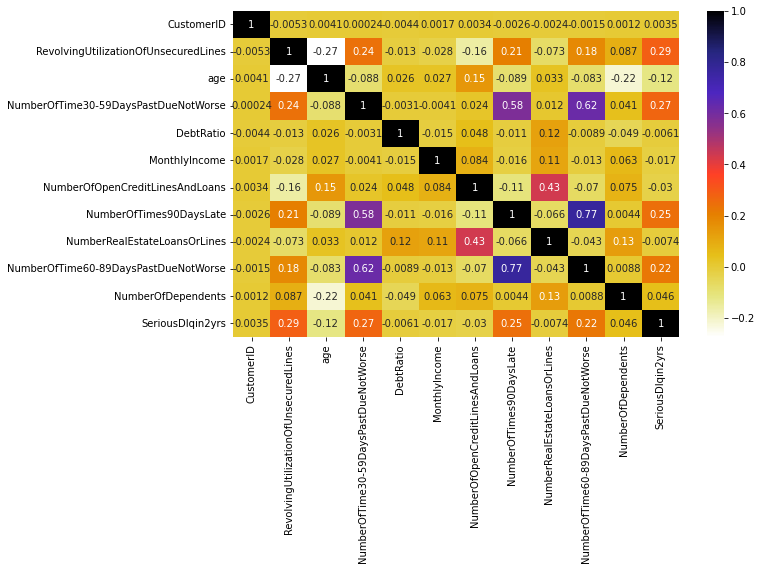

In [66]:
plt.figure(figsize=(10,6))
sns.heatmap(new_train.corr(), annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

* From the correlation heatmap above, we can see the most correlated values to SeriousDlqin2yrs are NumberOfTime30-59DaysPastDueNotWorse , NumberOfTime60-89DaysPastDueNotWorse and NumberOfTimes90DaysLate.
* **
* Number of Open Credit Lines and Loans and Number of Real Estate Loans or Lines also have a significant correlation

### Bivariate Analysis

In [67]:
def boxplot_violinplot(col1, col2):
    fig,[ax1,ax2]=plt.subplots(1,2,figsize=(12,5))
    sns.boxplot(x=col1, y=col2, data=new_train, palette='Set3',ax=ax1)
    sns.violinplot(x=col1, y=col2, data=new_train, palette='Set3',ax=ax2)
    plt.show()

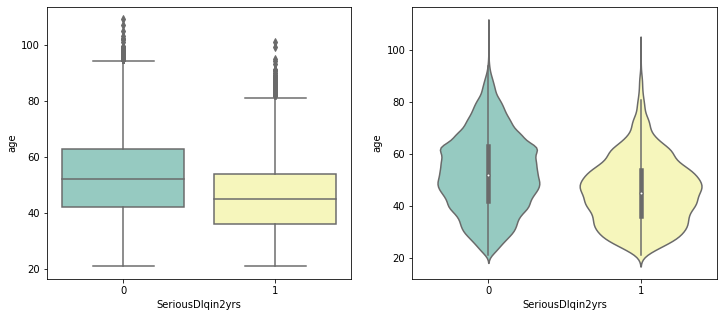

In [68]:
boxplot_violinplot('SeriousDlqin2yrs', 'age')

In [69]:
# Age has no significant on the target variable though most of the customers are in the mid 50 who has serious delinquency in 2 years

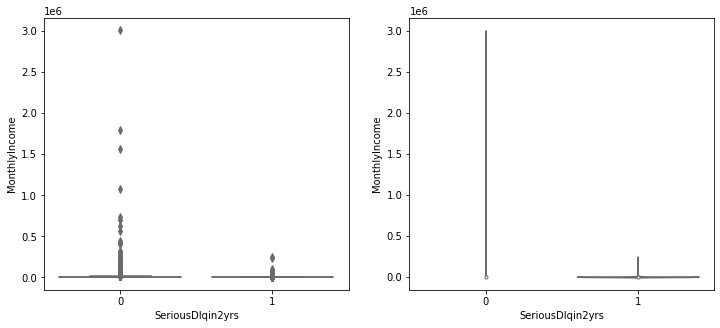

In [70]:
boxplot_violinplot('SeriousDlqin2yrs', 'MonthlyIncome')

In [71]:
# More or less similar relationship when target is 0 or 1

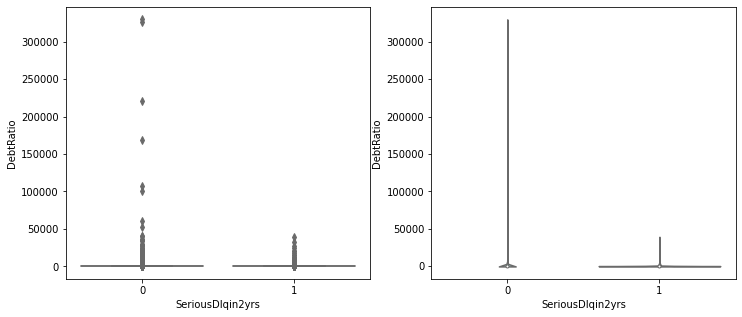

In [72]:
boxplot_violinplot('SeriousDlqin2yrs','DebtRatio')

In [73]:
# More or less similar relationship when target is 0 or 1

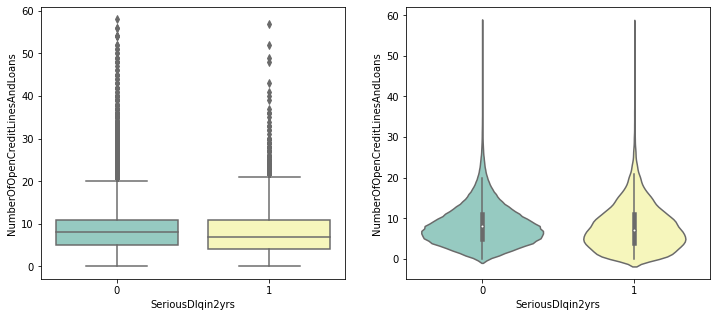

In [74]:
boxplot_violinplot('SeriousDlqin2yrs', 'NumberOfOpenCreditLinesAndLoans')

* It is expected that the higher the utlization ratio, the higher the default rate is. Let me look into that by plotting the utlization ratio to default rate

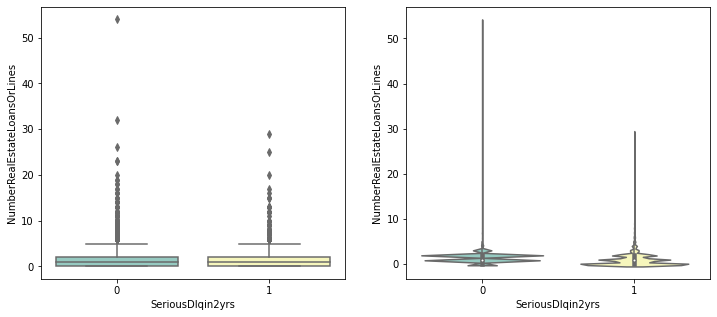

In [75]:
boxplot_violinplot('SeriousDlqin2yrs', 'NumberRealEstateLoansOrLines')

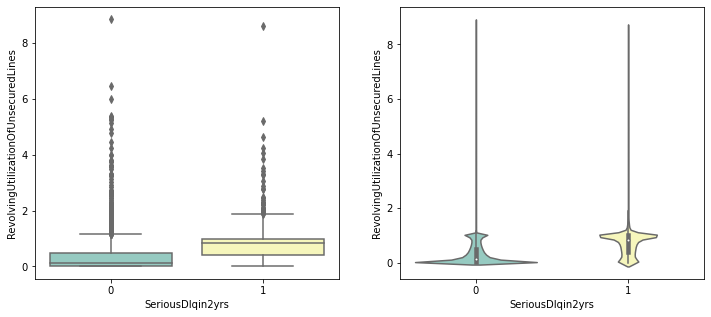

In [76]:
boxplot_violinplot('SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines')

In [77]:
# Feature description itself more the utlization of the credit resources or the ratio of amount owe to credit is more, serious delinquency is on a bit higher side

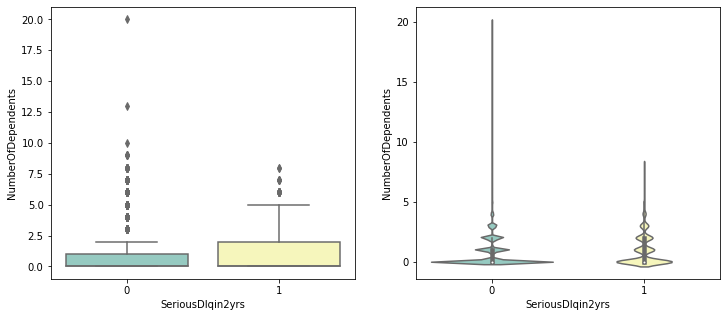

In [78]:
boxplot_violinplot('SeriousDlqin2yrs', 'NumberOfDependents')

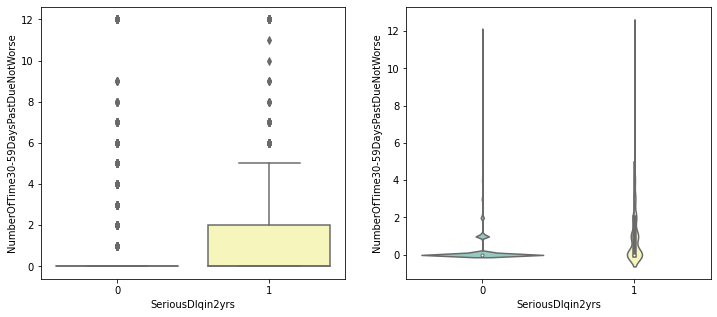

In [79]:
boxplot_violinplot('SeriousDlqin2yrs', 'NumberOfTime30-59DaysPastDueNotWorse')

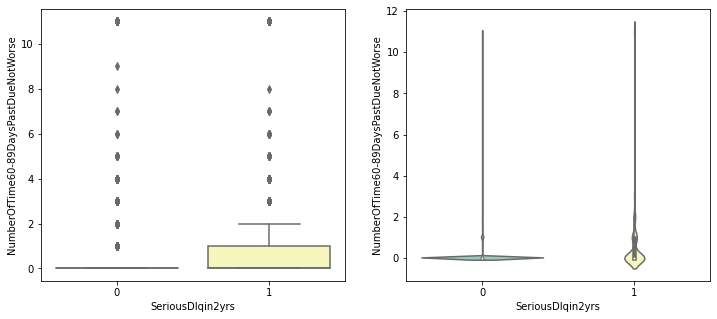

In [80]:
boxplot_violinplot('SeriousDlqin2yrs', 'NumberOfTime60-89DaysPastDueNotWorse')

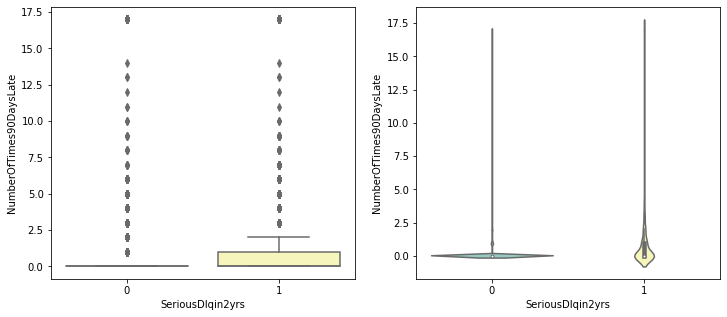

In [81]:
boxplot_violinplot('SeriousDlqin2yrs', 'NumberOfTimes90DaysLate')

* It is expected that the higher the utlization ratio, the higher the default rate is. Let me look into that by plotting the utlization ratio to default rate

* **Now let's move to the Feature Engineering section of our Notebook**

### Feature Engineering

In [82]:
dataset = [new_train, new_test]

* Making combined features

In [83]:
for data in dataset:
    
    data['CombinedPastDue']     = data['NumberOfTime30-59DaysPastDueNotWorse'] + data['NumberOfTime60-89DaysPastDueNotWorse'] + data['NumberOfTimes90DaysLate']
    data['CombinedCreditLoans'] = data['NumberOfOpenCreditLinesAndLoans'] + data['NumberRealEstateLoansOrLines']
    
new_train.columns    

Index(['CustomerID', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'SeriousDlqin2yrs', 'CombinedPastDue',
       'CombinedCreditLoans'],
      dtype='object')

* Interaction of the features

In [84]:
for data in dataset:

    data['MonthlyIncomePerPerson'] = data['MonthlyIncome']/(data['NumberOfDependents']+1)
    
    data['MonthlyDebt']            = data['MonthlyIncome']*data['DebtRatio']
    
    data['isRetired']              = np.where((data['age'] > 65), 1, 0)
    
    data['RevolvingLines']         = data['NumberOfOpenCreditLinesAndLoans']-data['NumberRealEstateLoansOrLines']
    data['hasRevolvingLines']      = np.where((data['RevolvingLines']>0),1,0)
    
    data['hasMultipleRealEstates'] = np.where((data['NumberRealEstateLoansOrLines']>=2),1,0)
    
    data['IsAlone']                = np.where((data['NumberOfDependents']==0),1,0)
    
new_train.columns

Index(['CustomerID', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'SeriousDlqin2yrs', 'CombinedPastDue',
       'CombinedCreditLoans', 'MonthlyIncomePerPerson', 'MonthlyDebt',
       'isRetired', 'RevolvingLines', 'hasRevolvingLines',
       'hasMultipleRealEstates', 'IsAlone'],
      dtype='object')

In [85]:
new_train.shape, new_test.shape

((119542, 21), (29946, 21))

In [86]:
print(new_train['SeriousDlqin2yrs'].sum()/len(new_train))
print()
print(new_test['SeriousDlqin2yrs'].sum()/len(new_test))

0.0670057385688712

0.06668670273158352


* ** Tackling Class Imbalance Problem using:**
* **
    * Upsampling the minority class(default rate)
    * Downsampling the majority class(non defaulters)
    * SMOTE - synthethic sampling

In [87]:
df_train = new_train.drop(columns=['CustomerID', 'SeriousDlqin2yrs'],axis=1)
y_train = new_train['SeriousDlqin2yrs']

df_test = new_test.drop(columns=['CustomerID', 'SeriousDlqin2yrs'],axis=1)
y_test = new_test['SeriousDlqin2yrs']

#### Upsampling

In [88]:
df_majority = new_train[new_train['SeriousDlqin2yrs']==0]
df_minority = new_train[new_train['SeriousDlqin2yrs']==1]

In [89]:
# replacing the samples keeping 100000 as the defaulters to keep in line with the non defaulters
df_minority_upsampled = resample(df_minority, replace=True, n_samples=100000, random_state=42)
df_upsampled = pd.concat([df_majority,df_minority_upsampled])
df_upsampled['SeriousDlqin2yrs'].value_counts()

0    111532
1    100000
Name: SeriousDlqin2yrs, dtype: int64

In [90]:
y_train_upsampled = df_upsampled['SeriousDlqin2yrs']

df_upsampled.drop(columns=['CustomerID', 'SeriousDlqin2yrs'],axis=1, inplace=True)

df_upsampled.shape, df_test.shape, y_train_upsampled.shape, y_test.shape

((211532, 19), (29946, 19), (211532,), (29946,))

#### Downsampling

In [91]:
new_train['SeriousDlqin2yrs'].value_counts()

0    111532
1      8010
Name: SeriousDlqin2yrs, dtype: int64

In [92]:
# keeping 8000 as  non defaulters to keep in line with the defaulters
df_majority_downsampled = resample(df_majority, n_samples=8000, random_state=42)
df_downsampled = pd.concat([df_minority,df_majority_downsampled])
df_downsampled['SeriousDlqin2yrs'].value_counts()

1    8010
0    8000
Name: SeriousDlqin2yrs, dtype: int64

In [93]:
y_train_downsampled = df_downsampled['SeriousDlqin2yrs']

df_downsampled.drop(columns=['CustomerID', 'SeriousDlqin2yrs'],axis=1, inplace=True)

df_downsampled.shape, df_test.shape, y_train_downsampled.shape, y_test.shape


((16010, 19), (29946, 19), (16010,), (29946,))

#### SMOTE

In [94]:
smote = SMOTE(sampling_strategy = 'minority',k_neighbors = 2,random_state=42)

os_data_X,os_data_y=smote.fit_resample(df_train,y_train)

In [95]:
os_data_X.shape, sum(os_data_y)/len(os_data_y)

((223064, 19), 0.5)

* Now the event rate in the training dataset is 50%

In [96]:
# Making a copy of the dataframes so that tarnsformed df and original df is separate to comapre results

In [97]:
os_data_X_tranformed  = os_data_X.copy()
df_test_transformed   = df_test.copy()

In [98]:
df_test_standaradized = df_test.copy()

In [99]:
df_downsampled_transformed = df_downsampled.copy()
df_upsampled_transformed   = df_upsampled.copy()

* ** Scaling of the features so convergence of the model towards global minima can be achieved and training can be done faster**
* We will be using a couple of Feature Transformation techniques:
* **
    * BoxCox Transformations
    * Standaradization

In [100]:
# We will check with how skewness changes after the transformations and we will check on SMOTE sampling technique dataset

#### Scaling features using BoxCox Transformations

In [101]:
def SkewMeasure(df):
    nonObjectColList = df.dtypes[df.dtypes != 'object'].index
    skewM = df[nonObjectColList].apply(lambda x: skew(x.dropna())).sort_values(ascending = False)
    skewM=pd.DataFrame({'skew':skewM})
    return skewM[abs(skewM)>0.5].dropna()

In [102]:
SkewMeasure(os_data_X_tranformed)

skew
MonthlyIncome                         146.968611
MonthlyIncomePerPerson                105.345969
MonthlyDebt                            90.058100
DebtRatio                              87.067428
NumberOfTime60-89DaysPastDueNotWorse    8.583851
NumberOfTimes90DaysLate                 8.078678
CombinedPastDue                         8.062644
NumberOfTime30-59DaysPastDueNotWorse    5.085588
NumberRealEstateLoansOrLines            3.790846
isRetired                               2.563314
NumberOfDependents                      1.428809
hasMultipleRealEstates                  1.355296
RevolvingLines                          1.254650
CombinedCreditLoans                     1.103838
NumberOfOpenCreditLinesAndLoans         1.087168
RevolvingUtilizationOfUnsecuredLines    0.807936
hasRevolvingLines                      -4.240447

In [103]:
skewM = SkewMeasure(os_data_X_tranformed)

for i in skewM.index:
    os_data_X_tranformed[i] = special.boxcox1p(os_data_X_tranformed[i],0.15) #lambda = 0.15
    df_test_transformed[i]  = special.boxcox1p(df_test_transformed[i],0.15) #lambda = 0.15
SkewMeasure(os_data_X_tranformed)

skew
NumberOfTime60-89DaysPastDueNotWorse  4.678528
NumberOfTimes90DaysLate               3.733055
isRetired                             2.563314
NumberOfTime30-59DaysPastDueNotWorse  2.097797
DebtRatio                             2.094686
MonthlyDebt                           1.908265
CombinedPastDue                       1.877240
hasMultipleRealEstates                1.355296
NumberOfDependents                    0.797379
NumberRealEstateLoansOrLines          0.696784
NumberOfOpenCreditLinesAndLoans      -0.563926
CombinedCreditLoans                  -0.605056
MonthlyIncomePerPerson               -1.251531
MonthlyIncome                        -1.944274
hasRevolvingLines                    -4.240447

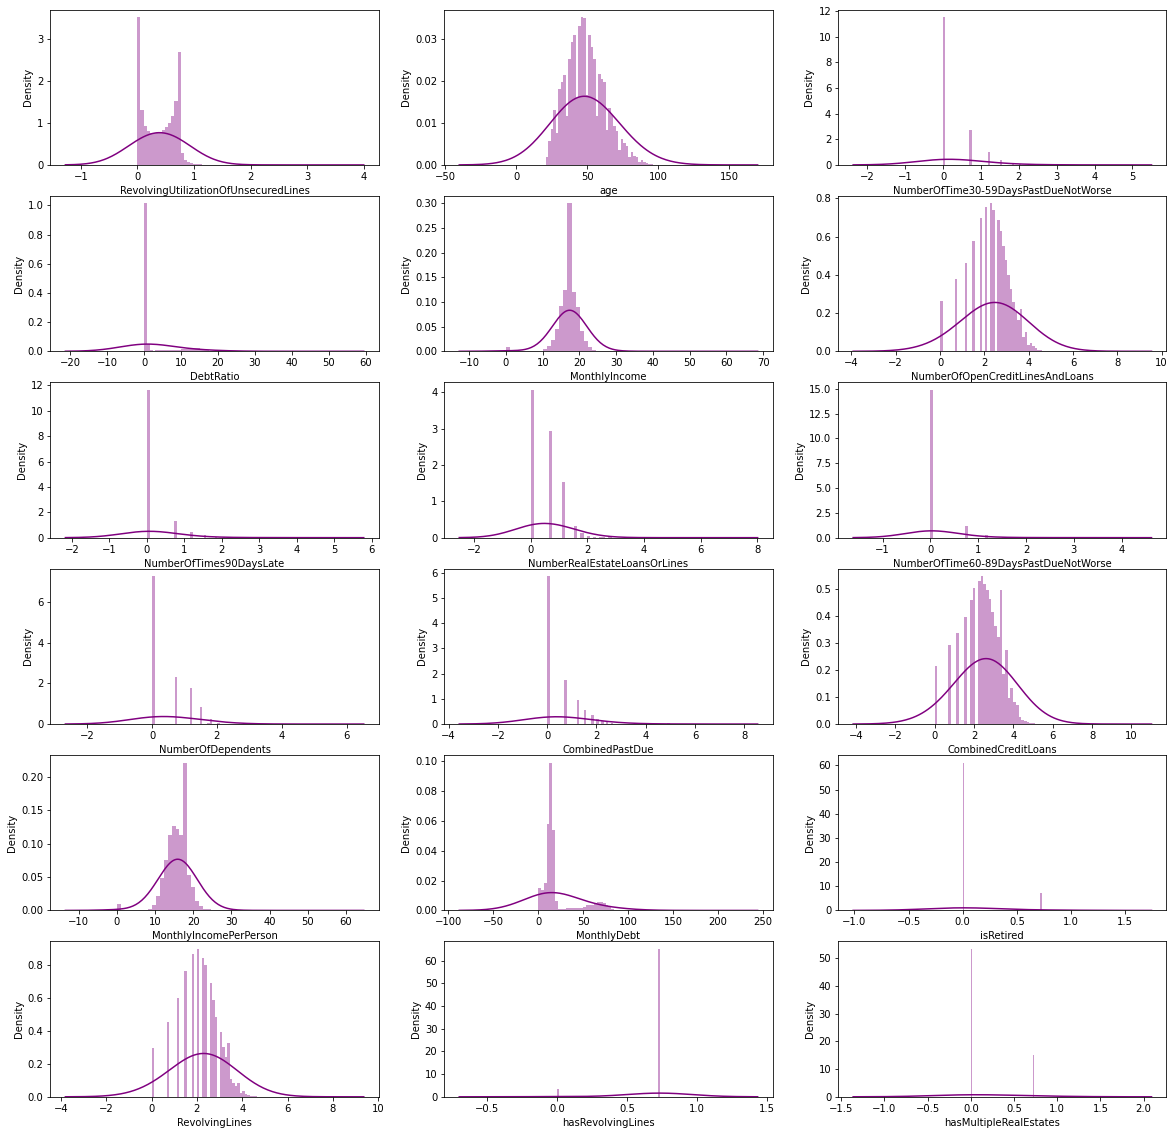

In [104]:
columnList = list(df_test_transformed.columns)

fig = plt.figure(figsize=[20,20])
for col,i in zip(columnList,range(1,19)):
    axes = fig.add_subplot(6,3,i)
    sns.distplot(os_data_X_tranformed[col],ax=axes, kde_kws={'bw':1.5}, color='purple')
plt.show()

* Skewness is reduced and now the graphs are looking good

In [105]:
df_train_transformed = df_train.copy()

skewM = SkewMeasure(df_train)

for i in skewM.index:
    df_train_transformed[i] = special.boxcox1p(df_train_transformed[i],0.15) #lambda = 0.15

#### Standaradization

In [106]:
scaler = StandardScaler().fit(os_data_X)

X_train_scaled = scaler.transform(os_data_X) 
X_test_scaled = scaler.transform(df_test)

In [107]:
scaler = StandardScaler().fit(df_upsampled_transformed)

X_train_scaled_upsampled = scaler.transform(df_upsampled_transformed) 
X_test_scaled_upsampled = scaler.transform(df_test_standaradized)

In [108]:
scaler = StandardScaler().fit(df_downsampled_transformed)

X_train_scaled_downsampled = scaler.transform(df_downsampled_transformed) 
X_test_scaled_downsampled = scaler.transform(df_test_standaradized)

### Modeling

* ** Training the model :**
    * **
    * We will be training the model using different algorithms 
    * We wil also be comparing the results using transformed dataset and the original dataset
    * We will check and compare on which algorithms transformations works and on which not.
    * We will be doing Cross Validation and will see if the model performance is fluctuating using the statistical measures such as mean and standarad deviation 
* **
* ** Predicting the customers from the test dataset and comapring with the true values from the test dataset using different evaluation metrics will give us which model to go for and which model is performing the best**
* **
* ** We will also be evaluating our model on different metrics and why some metrics might fail in our case study which is one of the most popular metric to evaluate a model performance **
* **
* ** Some common evaluation metric you will be seeing across all modeling algorithms are:**
    * ** Precision** - * How good a model is in predicting the events
        * True Positive/(True Positive + False Positives)
    * ** Recall** - * How good a model is able to capture relevant events(Coverage)
        * True Positive/(True Positive + False Negatives)
    * ** F1 Score** - * Harmonic mean between Precision and Recall, this metric penalized either one of the lower scorer metric so that trade off can be maintained
    * ** Area Under the Curve & ROC** - * how good a model is able to differentiate between the classes
        * It is plotted as False Positive Rate on the x-axis and True Positive Rate on the y-axis  using different thresholds.
        * The more the area or the line it is above straight diagonal line, the better is model performance as comapred to randomly predicting the classes
* **
* ** We will be comapring the different modeling techniques AUC results to see which ones are performing better as compared to others**
* **
* ** We will be tuning hyper parameters of the models to achieve better results and see how tuning increases performance if it does**

#### Neural Network

In [109]:
# custom metrics
def precision(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def recall(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [110]:
def fit_model(data, labels, test_data,test_label, epochs, batch_size):
    
    n_inputs = data.shape[1]
    model    = keras.Sequential()
    model.add(layers.Dense(16, activation ='relu', input_shape =(n_inputs, )))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(32,activation = 'relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(1,activation ='sigmoid'))
    
    model_file_name = 'MLP_predict_default_case_study.hdf5'
    ckpt = ModelCheckpoint(model_file_name, monitor='val_precision',
                           save_best_only=True, mode='max')
    early = EarlyStopping(monitor="val_recall", mode="max", patience=15)

    model.compile(optimizer = 'adam',
                 loss= 'binary_crossentropy',
                 metrics = [precision,recall])
    
    history = model.fit(data,
                       labels,
                       epochs=epochs,
                       batch_size=batch_size,
                       callbacks=[ckpt, early],
                       validation_data=(test_data,test_label))
    
    return model

In [111]:
def compute_precisions_thresolds(data, labels, test_data, test_label, epochs, batch_size):
    trained_model = fit_model(data, labels, test_data, test_label, epochs=epochs, batch_size=batch_size)
    y_test_pred   = trained_model.predict(test_data)
    
    P_macro = [] ; P_micro = [];  R_macro = [] ;R_micro = []; F1_macro = [] ;F1_micro = []; cut_off = [] ; metrics = pd.DataFrame()
    threshold_list = [0.25,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.96]
    for thres in threshold_list:
        cut_off.append(thres)
        y_test_pred_new = [1 if el>thres else 0 for el in y_test_pred]
        prec_macro            = round(precision_score(test_label, y_test_pred_new, pos_label=1, average='macro'),2)
        P_macro.append(prec_macro)
        prec_micro            = round(precision_score(test_label, y_test_pred_new, pos_label=1, average='micro'),2)
        P_micro.append(prec_micro)
        rec_macro             = round(recall_score(test_label, y_test_pred_new, pos_label=1,average='macro'),2)
        R_macro.append(rec_macro)
        rec_micro             = round(recall_score(test_label, y_test_pred_new, pos_label=1,average='micro'),2)
        R_micro.append(rec_micro)
        f1_macro              = round(f1_score(test_label, y_test_pred_new, average='macro'),2)
        F1_macro.append(f1_macro)
        f1_micro              = round(f1_score(test_label, y_test_pred_new, average='micro'),2)
        F1_micro.append(f1_micro)
        
    metrics = pd.DataFrame({'Threshold' : cut_off, 'Precision Macro' : P_macro, 'Precision Micro' : P_micro,'Recall Macro' : R_macro, 'Recall Micro' : R_micro,'F1 Score Macro' : F1_macro, 'F1 Score Micro' : F1_micro})
    return metrics.sort_values(by=['Threshold'], ascending=False)

* ** Appling Neural Network model on Box Cox transformed dataset**

In [112]:
box_cox_metrics = compute_precisions_thresolds(os_data_X_tranformed, os_data_y, df_test_transformed, y_test,epochs=15, batch_size=128)

Epoch 1/15
1743/1743 [==============================] - 5s 2ms/step - loss: 0.6063 - precision: 0.6996 - recall: 0.7055 - val_loss: 0.3966 - val_precision: 0.2172 - val_recall: 0.6888
Epoch 2/15
1743/1743 [==============================] - 3s 2ms/step - loss: 0.4664 - precision: 0.7664 - recall: 0.8219 - val_loss: 0.4817 - val_precision: 0.1771 - val_recall: 0.7800
Epoch 3/15
1743/1743 [==============================] - 3s 2ms/step - loss: 0.4470 - precision: 0.7748 - recall: 0.8335 - val_loss: 0.3925 - val_precision: 0.1982 - val_recall: 0.7047
Epoch 4/15
1743/1743 [==============================] - 4s 2ms/step - loss: 0.4365 - precision: 0.7769 - recall: 0.8360 - val_loss: 0.4352 - val_precision: 0.1847 - val_recall: 0.7469
Epoch 5/15
1743/1743 [==============================] - 4s 2ms/step - loss: 0.4303 - precision: 0.7797 - recall: 0.8366 - val_loss: 0.3888 - val_precision: 0.2015 - val_recall: 0.7016
Epoch 6/15
1743/1743 [==============================] - 3s 2ms/step - loss: 0.42

In [113]:
box_cox_metrics

Threshold  Precision Macro  Precision Micro  Recall Macro  Recall Micro  \
9       0.96             0.87             0.93          0.50          0.93   
8       0.95             0.86             0.93          0.50          0.93   
7       0.90             0.77             0.93          0.51          0.93   
6       0.80             0.71             0.93          0.58          0.93   
5       0.70             0.66             0.91          0.67          0.91   
4       0.60             0.60             0.84          0.74          0.84   
3       0.50             0.58             0.75          0.75          0.75   
2       0.40             0.57             0.68          0.75          0.68   
1       0.30             0.56             0.61          0.73          0.61   
0       0.25             0.55             0.56          0.71          0.56   

   F1 Score Macro  F1 Score Micro  
9            0.48            0.93  
8            0.49            0.93  
7            0.51            0.93  
6            0.61            0.93  
5            0.66            0.91  
4            0.62            0.84  
3            0.57            0.75  
2            0.53            0.68  
1            0.48            0.61  
0            0.45            0.56

* ** Applying Neural Network on Standardized dataset**

In [114]:
standardized_metrics = compute_precisions_thresolds(X_train_scaled, os_data_y, X_test_scaled, y_test,epochs=15, batch_size=128)

Epoch 1/15
1743/1743 [==============================] - 5s 2ms/step - loss: 0.4911 - precision: 0.7530 - recall: 0.8246 - val_loss: 0.4360 - val_precision: 0.1741 - val_recall: 0.7520
Epoch 2/15
1743/1743 [==============================] - 4s 2ms/step - loss: 0.4259 - precision: 0.7845 - recall: 0.8545 - val_loss: 0.3715 - val_precision: 0.2178 - val_recall: 0.6833
Epoch 3/15
1743/1743 [==============================] - 4s 2ms/step - loss: 0.3606 - precision: 0.8297 - recall: 0.8379 - val_loss: 0.3427 - val_precision: 0.2254 - val_recall: 0.6405
Epoch 4/15
1743/1743 [==============================] - 3s 2ms/step - loss: 0.3389 - precision: 0.8415 - recall: 0.8351 - val_loss: 0.3195 - val_precision: 0.2325 - val_recall: 0.6285
Epoch 5/15
1743/1743 [==============================] - 4s 2ms/step - loss: 0.3330 - precision: 0.8426 - recall: 0.8396 - val_loss: 0.3218 - val_precision: 0.2406 - val_recall: 0.6308
Epoch 6/15
1743/1743 [==============================] - 4s 2ms/step - loss: 0.32

In [115]:
standardized_metrics

Threshold  Precision Macro  Precision Micro  Recall Macro  Recall Micro  \
9       0.96             0.47             0.93          0.50          0.93   
8       0.95             0.67             0.93          0.50          0.93   
7       0.90             0.73             0.93          0.51          0.93   
6       0.80             0.72             0.93          0.54          0.93   
5       0.70             0.69             0.93          0.62          0.93   
4       0.60             0.64             0.90          0.70          0.90   
3       0.50             0.60             0.84          0.74          0.84   
2       0.40             0.58             0.78          0.75          0.78   
1       0.30             0.57             0.71          0.75          0.71   
0       0.25             0.57             0.68          0.74          0.68   

   F1 Score Macro  F1 Score Micro  
9            0.48            0.93  
8            0.48            0.93  
7            0.50            0.93  
6            0.55            0.93  
5            0.64            0.93  
4            0.67            0.90  
3            0.63            0.84  
2            0.59            0.78  
1            0.55            0.71  
0            0.53            0.68

* ** Applying Neural Network on Original Standaradized dataset**

In [116]:
scaler = StandardScaler().fit(df_train)

df_train_scaled = scaler.transform(df_train) 
df_test_scaled = scaler.transform(df_test)

In [117]:
base_metrics = compute_precisions_thresolds(df_train_scaled, y_train, df_test_scaled, y_test, epochs=10, batch_size=128)

Epoch 1/10
934/934 [==============================] - 3s 3ms/step - loss: 0.2246 - precision: 0.2975 - recall: 0.0682 - val_loss: 0.1886 - val_precision: 0.1047 - val_recall: 0.0138
Epoch 2/10
934/934 [==============================] - 2s 3ms/step - loss: 0.1917 - precision: 0.3350 - recall: 0.0524 - val_loss: 0.1853 - val_precision: 0.2066 - val_recall: 0.0305
Epoch 3/10
934/934 [==============================] - 2s 2ms/step - loss: 0.1874 - precision: 0.3772 - recall: 0.0625 - val_loss: 0.1847 - val_precision: 0.1724 - val_recall: 0.0242
Epoch 4/10
934/934 [==============================] - 2s 2ms/step - loss: 0.1855 - precision: 0.3482 - recall: 0.0619 - val_loss: 0.1844 - val_precision: 0.1261 - val_recall: 0.0172
Epoch 5/10
934/934 [==============================] - 2s 2ms/step - loss: 0.1849 - precision: 0.3452 - recall: 0.0578 - val_loss: 0.1842 - val_precision: 0.1346 - val_recall: 0.0182
Epoch 6/10
934/934 [==============================] - 2s 2ms/step - loss: 0.1844 - precisi

In [118]:
base_metrics

Threshold  Precision Macro  Precision Micro  Recall Macro  Recall Micro  \
9       0.96             0.47             0.93          0.50          0.93   
8       0.95             0.47             0.93          0.50          0.93   
7       0.90             0.47             0.93          0.50          0.93   
6       0.80             0.47             0.93          0.50          0.93   
5       0.70             0.47             0.93          0.50          0.93   
4       0.60             0.88             0.93          0.50          0.93   
3       0.50             0.79             0.94          0.55          0.94   
2       0.40             0.72             0.93          0.62          0.93   
1       0.30             0.69             0.92          0.68          0.92   
0       0.25             0.68             0.92          0.70          0.92   

   F1 Score Macro  F1 Score Micro  
9            0.48            0.93  
8            0.48            0.93  
7            0.48            0.93  
6            0.48            0.93  
5            0.48            0.93  
4            0.49            0.93  
3            0.58            0.94  
2            0.65            0.93  
1            0.69            0.92  
0            0.69            0.92

* **Applying Neural Network on Upsampled dataset**

In [119]:
upsampled_metrics = compute_precisions_thresolds(X_train_scaled_upsampled, y_train_upsampled, df_test_standaradized, y_test, epochs=10, batch_size=128)

Epoch 1/10
1653/1653 [==============================] - 4s 2ms/step - loss: 0.5056 - precision: 0.7608 - recall: 0.7294 - val_loss: 5754.7251 - val_precision: 0.0281 - val_recall: 0.0041
Epoch 2/10
1653/1653 [==============================] - 4s 2ms/step - loss: 0.4740 - precision: 0.7808 - recall: 0.7499 - val_loss: 9385.2119 - val_precision: 0.0260 - val_recall: 0.0036
Epoch 3/10
1653/1653 [==============================] - 4s 2ms/step - loss: 0.4703 - precision: 0.7796 - recall: 0.7545 - val_loss: 10395.8564 - val_precision: 0.0260 - val_recall: 0.0036
Epoch 4/10
1653/1653 [==============================] - 4s 2ms/step - loss: 0.4682 - precision: 0.7793 - recall: 0.7587 - val_loss: 9817.2949 - val_precision: 0.0239 - val_recall: 0.0036
Epoch 5/10
1653/1653 [==============================] - 4s 2ms/step - loss: 0.4672 - precision: 0.7782 - recall: 0.7605 - val_loss: 8350.0957 - val_precision: 0.0043 - val_recall: 4.2735e-04
Epoch 6/10
1653/1653 [==============================] - 4s 2

In [120]:
upsampled_metrics

Threshold  Precision Macro  Precision Micro  Recall Macro  Recall Micro  \
9       0.96             0.47             0.93           0.5          0.93   
8       0.95             0.47             0.93           0.5          0.93   
7       0.90             0.47             0.93           0.5          0.93   
6       0.80             0.47             0.93           0.5          0.93   
5       0.70             0.47             0.93           0.5          0.93   
4       0.60             0.47             0.93           0.5          0.93   
3       0.50             0.47             0.93           0.5          0.93   
2       0.40             0.47             0.93           0.5          0.93   
1       0.30             0.50             0.93           0.5          0.93   
0       0.25             0.49             0.93           0.5          0.93   

   F1 Score Macro  F1 Score Micro  
9            0.48            0.93  
8            0.48            0.93  
7            0.48            0.93  
6            0.48            0.93  
5            0.48            0.93  
4            0.48            0.93  
3            0.48            0.93  
2            0.48            0.93  
1            0.48            0.93  
0            0.48            0.93

* **Applying Neural Network on Downsampled dataset**

In [121]:
downsampled_metrics = compute_precisions_thresolds(X_train_scaled_downsampled, y_train_downsampled, df_test_standaradized, y_test, epochs=10, batch_size=128)

Epoch 1/10
126/126 [==============================] - 1s 5ms/step - loss: 0.6877 - precision: 0.5768 - recall: 0.6083 - val_loss: 38257.8125 - val_precision: 0.0631 - val_recall: 0.3442
Epoch 2/10
126/126 [==============================] - 1s 5ms/step - loss: 0.5580 - precision: 0.7212 - recall: 0.7407 - val_loss: 61255.6953 - val_precision: 0.0631 - val_recall: 0.2447
Epoch 3/10
126/126 [==============================] - 1s 4ms/step - loss: 0.5308 - precision: 0.7552 - recall: 0.7346 - val_loss: 85866.3984 - val_precision: 0.0634 - val_recall: 0.2655
Epoch 4/10
126/126 [==============================] - 1s 4ms/step - loss: 0.5209 - precision: 0.7659 - recall: 0.7469 - val_loss: 84411.1094 - val_precision: 0.0534 - val_recall: 0.1531
Epoch 5/10
126/126 [==============================] - 1s 4ms/step - loss: 0.5161 - precision: 0.7665 - recall: 0.7506 - val_loss: 65799.6406 - val_precision: 0.0539 - val_recall: 0.1533
Epoch 6/10
126/126 [==============================] - 1s 5ms/step - lo

In [122]:
downsampled_metrics

Threshold  Precision Macro  Precision Micro  Recall Macro  Recall Micro  \
9       0.96             0.49             0.75          0.48          0.75   
8       0.95             0.49             0.75          0.48          0.75   
7       0.90             0.49             0.75          0.48          0.75   
6       0.80             0.49             0.75          0.48          0.75   
5       0.70             0.49             0.75          0.48          0.75   
4       0.60             0.49             0.75          0.48          0.75   
3       0.50             0.49             0.75          0.48          0.75   
2       0.40             0.49             0.75          0.48          0.75   
1       0.30             0.49             0.75          0.48          0.75   
0       0.25             0.49             0.75          0.48          0.75   

   F1 Score Macro  F1 Score Micro  
9            0.47            0.75  
8            0.47            0.75  
7            0.47            0.75  
6            0.47            0.75  
5            0.47            0.75  
4            0.47            0.75  
3            0.47            0.75  
2            0.47            0.75  
1            0.47            0.75  
0            0.47            0.75

* It can be cleary seen that Deep learning models require scaling of the features so that error can be minimised when features are nearly of the same scale so that bakcpropogation of errors can be there which results in better optimization
* **
* No effect on Neural Network Models whether samples are downsampled or upsampled but that is not the case when synthetic sampling is used
* **
* Results are more or less the same using Box Cox transformations and Standaradization 

* **Training the model and predicting on unseen dataset:**
    * In total 4 modeling techniques are used - 
        * ** Logistic Regression**
        * ** Random Forest**
        * ** XGBoost**
        * ** Light GBM**
* **
    * Metrics will be calculated using each modeling technique
    * Confusion Matrix numbers are TN, FP, FN, TP
* **
   * **A joint plot of ROC AUC will be made to see the performance of classifiers**

#### Various ML models

In [123]:
def cal_score(y_test, y_pred): 
    cm              = confusion_matrix(y_test, y_pred)
    prec_scr_macro  = precision_score(y_test, y_pred, average='macro')*100
    prec_scr_micro  = precision_score(y_test, y_pred, average='micro')*100
    rec_scr_macro   = recall_score(y_test ,y_pred, average='macro')*100
    rec_scr_micro   = recall_score(y_test ,y_pred, average='micro')*100
    f1_scr_macro    = f1_score(y_test, y_pred, average='macro')*100 
    f1_scr_micro    = f1_score(y_test, y_pred, average='micro')*100 
    return prec_scr_macro, prec_scr_micro, rec_scr_macro, rec_scr_micro, f1_scr_macro, f1_scr_micro, cm

In [124]:
def metrics_calculation(classifier, training_data, testing_data, training_label, testing_label):
    
    result = []
    cols = ['Mean Accuracy', 'Accuracy deviation', 'Precision Macro', 'Precision Micro', 'Recall Macro','Recall Micro', 'F1 Score Macro', 'F1 Score Micro', 'Confusion Matrix']
    
    crs_val     = cross_val_score(classifier, training_data, training_label, cv=5)
    mean_acc = round(np.mean(crs_val),3)
    std_acc  = round(np.std(crs_val),3)
    classifier.fit(training_data, training_label)
    predictions = classifier.predict(testing_data)
    prec_scr_macro, prec_scr_micro, rec_scr_macro, rec_scr_micro, f1_scr_macro, f1_scr_micro, cm = cal_score(testing_label, predictions)
    result.extend([mean_acc,std_acc, prec_scr_macro, prec_scr_micro, rec_scr_macro, rec_scr_micro, f1_scr_macro, f1_scr_micro, cm])
    series_result = pd.Series(data=result, index=cols)
    
    return series_result


In [125]:
clf_dict = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'Logistic Regression' : LogisticRegression(random_state=42),
    'Light GBM' : LGBMClassifier(random_state=42)
}

* **Logistic Regression** : 
* **
    * 1/(1+e^-value)
   * **
    * p(x) = e^(b0+b1*X)/(1+e^(b0+b1*X))
    * ln(p(X)/1-p(X)) = b0+b1*X

* ** Evolution of Tree Based Algorithms and going towards XGboost** -
* **
* **Decision Tree** : A graphical representation of possible solutions to a decision based on certain conditions.
* **
* **Bagging** : Bootstrap aggregating or Bagging is a ensemble meta-algorithm combining predictions from multiple decision trees through a majority voting mechanism.
* **
* **Random Forest** : Bagging based algorithm where only a subset of features are selected at random to build a forest or collection of decision trees.
* **
* **Boosting** : Models are built sequentially by minizing the errors from previous models while increasing(boosting) influence of high-performing models.
* **
* **Gradient Boosting** : It employs gradient descent algorithm to minimize errors in sequential models.
* **
* **XGBoost** : Optimized Gradient Boosting algorithm through parallel processing, tree-pruning,handling missing values and regularization to avoid overfitting/bias.

* **Frameowrk of Boosting**:
    * F1(x) <- F0(x) + h1(x)
    * F2(x) <- F1(x) + h2(x)
    * Fm(x) <- Fm-1(x) + hm(x)

* ** Training Box Cox transformed dataset using ML algorithms**

In [126]:
frame = {}
for key in clf_dict:

    classifier_result = metrics_calculation(clf_dict[key], os_data_X_tranformed, df_test_transformed, os_data_y, y_test)
    frame[key]    = classifier_result
        
box_cox_smote_df = pd.DataFrame(frame)
box_cox_smote_df

[12:23:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:23:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:24:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:24:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

Random Forest  \
Mean Accuracy                              0.935   
Accuracy deviation                         0.019   
Precision Macro                        62.425031   
Precision Micro                        89.117077   
Recall Macro                            68.03833   
Recall Micro                           89.117077   
F1 Score Macro                         64.473731   
F1 Score Micro                         89.117077   
Confusion Matrix    [[25814, 2135], [1124, 873]]   

                                         XGBoost  \
Mean Accuracy                              0.883   
Accuracy deviation                         0.025   
Precision Macro                        60.296604   
Precision Micro                         85.59073   
Recall Macro                           71.077874   
Recall Micro                            85.59073   
F1 Score Macro                         62.691185   
F1 Score Micro                          85.59073   
Confusion Matrix    [[24546, 3403], [912, 1085]]   

                             Logistic Regression                     Light GBM  
Mean Accuracy                              0.799                         0.857  
Accuracy deviation                         0.005                         0.018  
Precision Macro                        58.471836                     59.710637  
Precision Micro                        79.756896                     83.092901  
Recall Macro                           73.718188                     73.622236  
Recall Micro                           79.756896                     83.092901  
F1 Score Macro                         59.348598                     61.707495  
F1 Score Micro                         79.756896                     83.092901  
Confusion Matrix    [[22551, 5398], [664, 1333]]  [[23631, 4318], [745, 1252]]

* ** Training Standaradized dataset using ML algorithms**

In [127]:
frame_std = {}
for key in clf_dict:

    classifier_result_std = metrics_calculation(clf_dict[key], X_train_scaled, X_test_scaled, os_data_y, y_test)
    frame_std[key]    = classifier_result_std
        
standardized_smote_df = pd.DataFrame(frame_std)
standardized_smote_df

[12:29:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:30:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:30:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:30:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

Random Forest  \
Mean Accuracy                              0.935   
Accuracy deviation                         0.019   
Precision Macro                        62.672365   
Precision Micro                        89.197222   
Recall Macro                           68.429994   
Recall Micro                           89.197222   
F1 Score Macro                         64.773728   
F1 Score Micro                         89.197222   
Confusion Matrix    [[25823, 2126], [1109, 888]]   

                                         XGBoost  \
Mean Accuracy                              0.883   
Accuracy deviation                         0.024   
Precision Macro                        60.112671   
Precision Micro                        85.440459   
Recall Macro                           70.811382   
Recall Micro                           85.440459   
F1 Score Macro                          62.44954   
F1 Score Micro                         85.440459   
Confusion Matrix    [[24509, 3440], [920, 1077]]   

                             Logistic Regression                     Light GBM  
Mean Accuracy                               0.83                         0.857  
Accuracy deviation                         0.018                         0.018  
Precision Macro                        59.526011                      59.71291  
Precision Micro                        84.381887                     82.986042  
Recall Macro                           70.918486                     73.797475  
Recall Micro                           84.381887                     82.986042  
F1 Score Macro                         61.642565                     61.690401  
F1 Score Micro                         84.381887                     82.986042  
Confusion Matrix    [[24163, 3786], [891, 1106]]  [[23589, 4360], [735, 1262]]

* ** Training Original dataset with using hyperparameter which is balancing minority class as per the majority class**

In [128]:
clf_dict_balanced = {
    'Random Forest': RandomForestClassifier(random_state=42, class_weight = {0:1, 1:10}),
    'XGBoost': XGBClassifier(random_state=42, scale_pos_weight = 10),
    'Logistic Regression' : LogisticRegression(random_state=42, class_weight = {0:1, 1:10}),
    'Light GBM' : LGBMClassifier(random_state=42, scale_pos_weight = 10)
}

In [129]:
frame_balanced = {}
for key in clf_dict_balanced:

    classifier_result_balanced = metrics_calculation(clf_dict_balanced[key], df_train, df_test, y_train, y_test)
    frame_balanced[key]    = classifier_result_balanced
        
balanced_df = pd.DataFrame(frame_balanced)
balanced_df

[12:33:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:33:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:33:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:34:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

Random Forest                       XGBoost  \
Mean Accuracy                             0.935                         0.866   
Accuracy deviation                          0.0                         0.001   
Precision Macro                       74.282694                     61.604048   
Precision Micro                       93.488279                     85.928004   
Recall Macro                          56.895917                     74.536611   
Recall Micro                          93.488279                     85.928004   
F1 Score Macro                        59.853718                     64.433248   
F1 Score Micro                        93.488279                     85.928004   
Confusion Matrix    [[27703, 246], [1704, 293]]  [[24506, 3443], [771, 1226]]   

                           Logistic Regression                     Light GBM  
Mean Accuracy                            0.929                         0.851  
Accuracy deviation                       0.002                         0.002  
Precision Macro                      48.350661                     61.426655  
Precision Micro                      92.326187                     84.715822  
Recall Macro                         49.717254                     76.607298  
Recall Micro                         92.326187                     84.715822  
F1 Score Macro                       48.478376                     64.142619  
F1 Score Micro                       92.326187                     84.715822  
Confusion Matrix    [[27637, 312], [1986, 11]]  [[24026, 3923], [654, 1343]]

* ** XGBoost and Light GBM are performing better in terms of Recall & Light GBM whereas Random Forest in Precision**

* ** Training Scaled oiginal dataset with using hyperparameter which is balancing minority class as per the majority class**

In [130]:
frame_balanced_scaled= {}
for key in clf_dict_balanced:

    classifier_result_balanced_scaled = metrics_calculation(clf_dict_balanced[key], df_train_transformed, df_test_transformed, y_train, y_test)
    frame_balanced_scaled[key]    = classifier_result_balanced_scaled
        
balanced_df_scaled = pd.DataFrame(frame_balanced_scaled)
balanced_df_scaled

[12:36:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:36:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:36:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:36:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

Random Forest                       XGBoost  \
Mean Accuracy                             0.935                         0.866   
Accuracy deviation                          0.0                         0.001   
Precision Macro                       74.123954                     61.601176   
Precision Micro                       93.474922                     85.924664   
Recall Macro                          56.726021                     74.534822   
Recall Micro                          93.474922                     85.924664   
F1 Score Macro                        59.619149                     64.429475   
F1 Score Micro                        93.474922                     85.924664   
Confusion Matrix    [[27706, 243], [1711, 286]]  [[24505, 3444], [771, 1226]]   

                             Logistic Regression                     Light GBM  
Mean Accuracy                              0.855                         0.851  
Accuracy deviation                         0.003                         0.002  
Precision Macro                        61.211486                     61.426655  
Precision Micro                        85.190009                     84.715822  
Recall Macro                           74.861954                     76.607298  
Recall Micro                           85.190009                     84.715822  
F1 Score Macro                         63.900467                     64.142619  
F1 Score Micro                         85.190009                     84.715822  
Confusion Matrix    [[24254, 3695], [740, 1257]]  [[24026, 3923], [654, 1343]]

* **Logistic Regression metrics are changed while all other model metrics remain same**
* Hence, Logistic Regression algorithm requires scaling of features whereas tree based doesn't

* ** Plotting ROC AUC for the ML models for the transformed dataset**

In [131]:
models = [
    {
    'label': 'Random Forest',
    'model': RandomForestClassifier(random_state=42)
    },
    {
    'label' : 'XGBoost',
    'model' : XGBClassifier(random_state=42)
    },
    {
    'label' : 'Logistic Regression',
    'model' : LogisticRegression(random_state=42)
    },
    {
    'label' : 'Light GBM',
    'model' : LGBMClassifier(random_state=42)
    }
]

In [132]:
def plot_multiplt_rocauc(models,train_X, train_y ,dev_X, dev_y):
    
    for m in models:
        model = m['model']   
        model.fit(train_X, train_y)
        y_pred = model.predict(dev_X)
        pred   = model.predict_proba(dev_X)
        pred_new = [i[1] for i in pred]
        fpr, tpr, thresholds = roc_curve(dev_y, pred_new)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], roc_auc))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1-Specificity(False Positive Rate)')
    plt.ylabel('Sensitivity(True Positive Rate)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()   # Display
    
    return 

[12:38:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


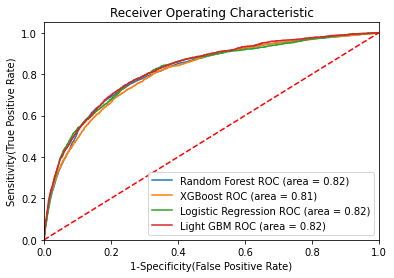

In [133]:
plot_multiplt_rocauc(models,os_data_X_tranformed,os_data_y, df_test_transformed, y_test)

* AUC of all the models are on a similar scale except the XGBoost model which is 0.1 on a higher side

* AUC of XGBoost Light GBM are performing beyeer than the others

* **Key takeaways:**
* **
    * Tree Based model doesn't require scaling of the features
    * Statistical - Logistic Regression requires scaling of the features
    * Upsampling of the Minority Class, Downsampling of the Majority Class and SMOTE sampling results are not better as compared to hyperparamater turning on using class weights in the model itself
    
* ** We will be proceeding with the original dataset without scaling of the featues but using class weights in the model itself**
    

* ** Feature Importance**
    * We will be plotting top features by importance of all the ML algorithms
    * we will be plotting Logistic Regression features by correlation

In [134]:
def plot_feature_importances(model, data):
    plt.figure(figsize=(8,6))
    n_features = data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), data.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

Model is  Random Forest
Model is  XGBoost
Model is  Light GBM


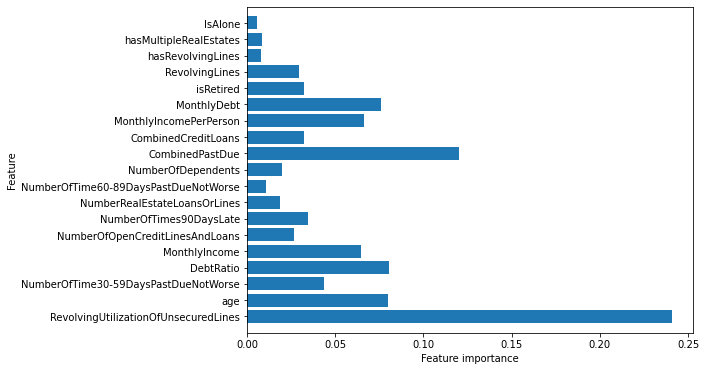

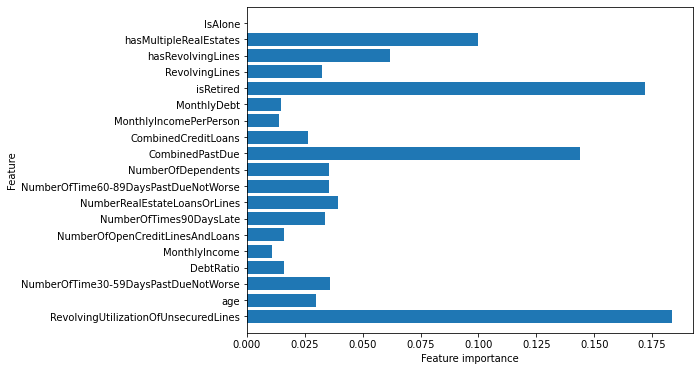

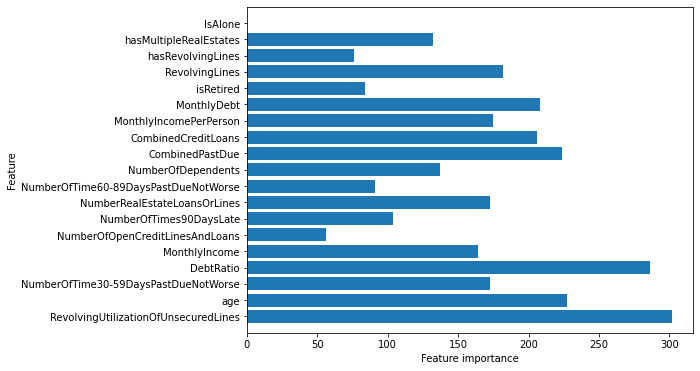

In [135]:
for key in clf_dict.keys():
  if key =='Logistic Regression':
    continue
  else:
    print('Model is ', key)
    plot_feature_importances(clf_dict[key], os_data_X_tranformed)

* In all ML models, ratio of amount owed to the credit limit is the top feature followed by Combined Past Due which is the summation of all dues by a borrower
* **
* In Light GBM model, others features are also contributing to a greater extent

In [136]:
logreg = LogisticRegression(random_state=42)
logreg.fit(os_data_X_tranformed, os_data_y)

coeff_df = pd.DataFrame(os_data_X_tranformed.columns)
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

Feature  Correlation
0   RevolvingUtilizationOfUnsecuredLines     3.775903
10                       CombinedPastDue     3.133607
11                   CombinedCreditLoans     1.384484
12                MonthlyIncomePerPerson     0.422497
5        NumberOfOpenCreditLinesAndLoans     0.273566
9                     NumberOfDependents     0.264463
13                           MonthlyDebt     0.017499
1                                    age    -0.005155
3                              DebtRatio    -0.082801
4                          MonthlyIncome    -0.430498
7           NumberRealEstateLoansOrLines    -0.564797
17                hasMultipleRealEstates    -0.992004
15                        RevolvingLines    -1.141996
6                NumberOfTimes90DaysLate    -1.169869
18                               IsAlone    -1.209368
8   NumberOfTime60-89DaysPastDueNotWorse    -1.640238
2   NumberOfTime30-59DaysPastDueNotWorse    -1.858652
16                     hasRevolvingLines    -2.016758
14                             isRetired    -2.633600

* Positive coefficients increase the log-odds of the response (and thus increase the probability), and negative coefficients decrease the log-odds of the response (and thus decrease the probability)

#### Feature Selection using RFECV

* We will be using RFECV on * **Random Forest** to remove correlated features because they might be providing the same information

In [137]:
def RFE(model, training_data, training_label):
    rfc = model
    rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(5), scoring='roc_auc')
    rfecv.fit(training_data, training_label)

    print('Optimal number of features: {}'.format(rfecv.n_features_))
    training_data_rfe = training_data.drop(training_data.columns[np.where(rfecv.support_ == False)[0]], axis=1)
    
    plt.figure(figsize=(16, 9))
    plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
    plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
    plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)
    plt.show()
    
    dset = pd.DataFrame()
    dset['attr'] = training_data.columns
    dset['importance'] = rfecv.estimator_.feature_importances_

    dset = dset.sort_values(by='importance', ascending=False)


    plt.figure(figsize=(16, 14))
    plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
    plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
    plt.xlabel('Importance', fontsize=14, labelpad=20)
    plt.show()
    
    return training_data_rfe.columns.tolist()

In [138]:
rfc = RandomForestClassifier(random_state=42)
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(5), scoring='roc_auc')
rfecv.fit(os_data_X_tranformed, os_data_y)

print('Optimal number of features: {}'.format(rfecv.n_features_))

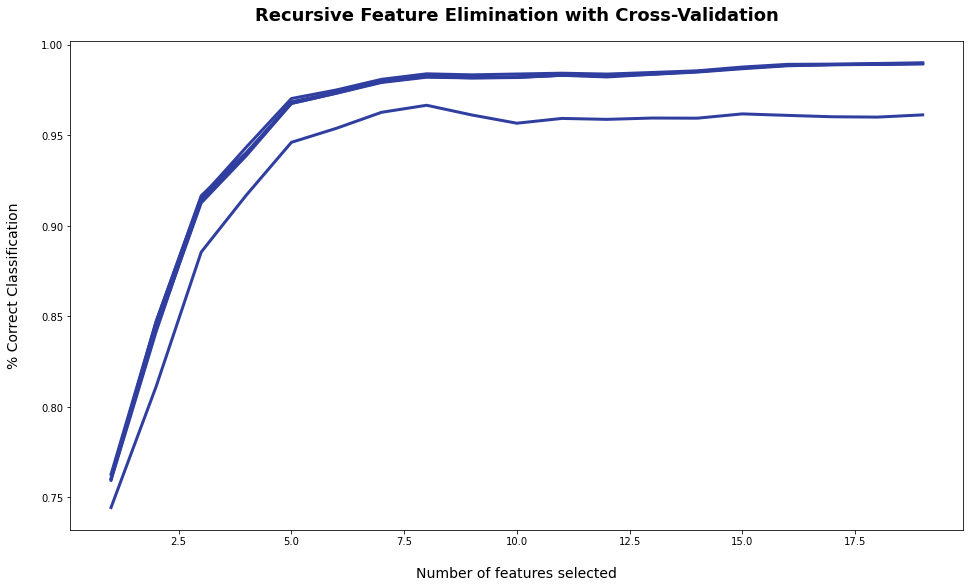

In [ ]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

In [ ]:
print(np.where(rfecv.support_ == False)[0])

os_data_X_tranformed_rfe = os_data_X_tranformed.drop(os_data_X_tranformed.columns[np.where(rfecv.support_ == False)[0]], axis=1)
os_data_X_tranformed_rfe.columns

[]


Index(['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'CombinedPastDue', 'CombinedCreditLoans',
       'MonthlyIncomePerPerson', 'MonthlyDebt', 'isRetired', 'RevolvingLines',
       'hasRevolvingLines', 'hasMultipleRealEstates', 'IsAlone'],
      dtype='object')

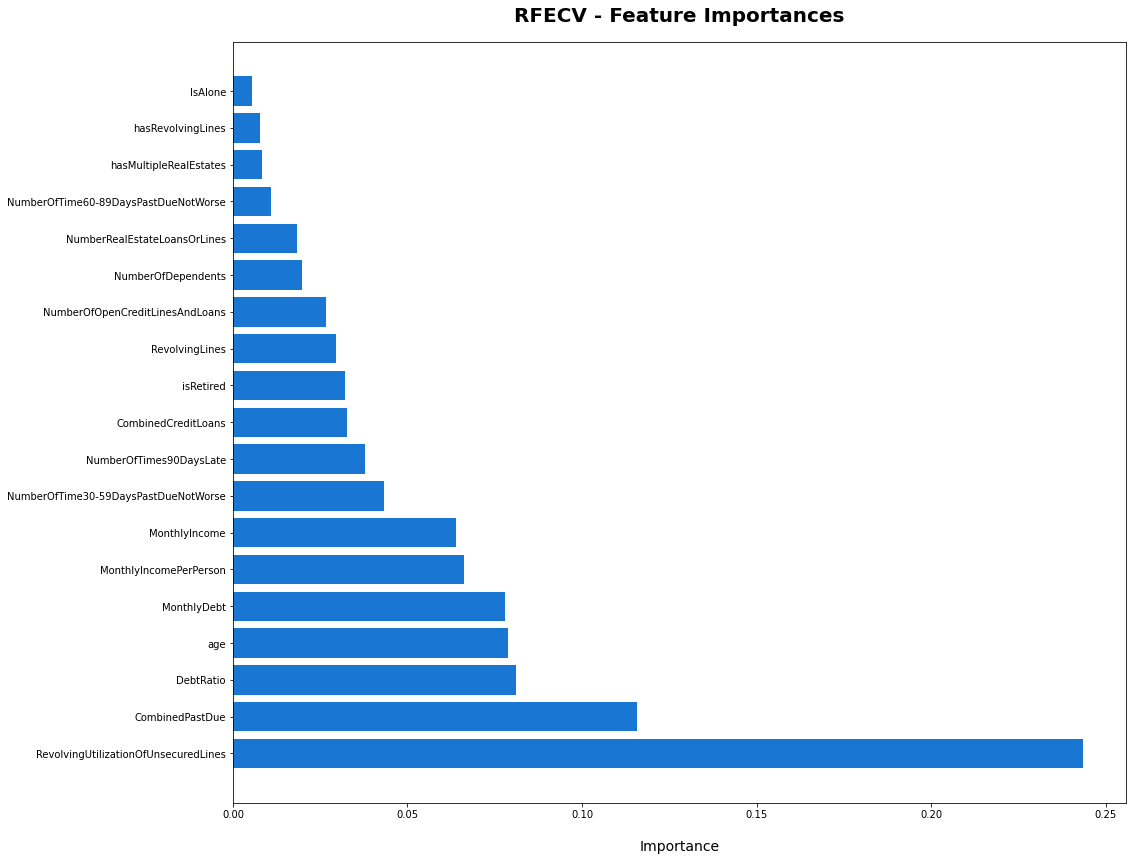

In [ ]:
dset = pd.DataFrame()
dset['attr'] = os_data_X_tranformed.columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(16, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

* Since our optimal performance is with the complete features and no feature is eliminated, we wil be proceeding with the complete Feature Engineered inputs

#### Hypter Paramter Tuning for the Random Forest, XGBoost, and LightGBM
* We will be using GridSearchCV for hyperparamater tuning

* Now we will be using Metrics such as Precision, Recall, F1 Score on class 1 only
* Previously * **macro** and * **micro** were used to give idea how these 2 separate metrics are calculated

In [ ]:
def hyperparameter_tuning(classifier, training_dataset, test_dataset, training_label, test_label):
    
    result = []
    cols = ['Precision', 'Recall', 'F1 Score', 'Confusion Matrix']
    
    model_name = {}
    class_str = str(classifier)
    if 'Random' in class_str:
        param_grid={
    "n_estimators":[27,36,100,200],
    "max_depth":[5,7,9,15],
    "min_samples_leaf":[2,4,6,8]
        }
        model = GridSearchCV(classifier, param_grid = param_grid, cv=StratifiedKFold(5))
        model.fit(training_dataset, training_label)
        best_est_model = model.best_estimator_
        model_name[class_str] = best_est_model
        best_est_model.fit(training_dataset, training_label)
        y_pred = best_est_model.predict(test_dataset)

    elif 'XG' in class_str:
        model_name = {}
        parameters = {
    'n_estimators': [100, 200], 
  'max_depth': [3, 5, 8], 
  'gamma' : [0.25,0.5,1],
  'reg_alpha': [0.1, 0.25, 0.5],
  'reg_lambda': [0.5,1,1.15],
  'scale_pos_weight' : [8,10,12,15]
    }
        model = GridSearchCV(classifier, parameters, scoring="neg_log_loss", cv = StratifiedKFold(5), n_jobs = -1, verbose = 2)
        
        model.fit(training_dataset, training_label)
        best_est_model = model.best_estimator_
        model_name[class_str] = best_est_model
        best_est_model.fit(training_dataset, training_label)
        y_pred = best_est_model.predict(test_dataset)
        
    else:
        model_name = {}
        param_grid = {'n_estimators': [100,250,400],
          'min_split_gain' : [0.25,0.45,0.7],
         'max_depth': [4,7,10],
         'subsample': [0.65,0.85],
         'colsample_bytree': [0.45,0.65,0.85],
         'reg_lambda': [0.5,1,3,5],
         'num_leaves' : [30,50,70],
         'min_data_in_leaf' : [100,400,600]
         }
        
        model = GridSearchCV(estimator = classifier, param_grid = param_grid, 
                          cv = StratifiedKFold(5), n_jobs = -1, verbose = 2)
        
        model.fit(training_dataset, training_label)
        best_est_model = model.best_estimator_
        model_name[class_str] = best_est_model
        best_est_model.fit(training_dataset, training_label)
        y_pred = best_est_model.predict(test_dataset)
        
    prec_scr, rec_scr, f1_scr, cm = cal_score(test_label, y_pred)
    result.extend([prec_scr, rec_scr, f1_scr, cm])
    series_result = pd.Series(data=result, index=cols)   
    
    return series_result, model_name

In [ ]:
frame_hyperparamater = {} ; model_params = []
for key in clf_dict:
  print(key)
  if key == 'Logistic Regression':
    continue
    hyperparamater_result, model_paramters = hyperparameter_tuning(clf_dict[key], df_train, df_test, y_train, y_test)
    frame_hyperparamater[key]    = hyperparamater_result
    model_params.append(model_paramters)
        
tuned_df = pd.DataFrame(frame_hyperparamater)

Random Forest
XGBoost
Logistic Regression
Light GBM


In [ ]:
model_params

[]

In [ ]:
clf_dict_balanced = {'Random Forest': RandomForestClassifier(max_depth=15, min_samples_leaf=8, n_estimators=200, random_state=42, class_weight={0:1,1:10}),
           'XGBoost': XGBClassifier(gamma=1, max_depth=8, n_estimators=200, random_state=42, reg_alpha=0.5, reg_lambda=1.15, scale_pos_weight=10),
            'Logistic Regression': LogisticRegression(random_state=42, class_weight={0:1,1:10}),
            'Light GBM': LGBMClassifier(colsample_bytree=0.65, max_depth=4, min_data_in_leaf=400, min_split_gain=0.25, num_leaves=70, random_state=42, reg_lambda=5, subsample=0.65, scale_pos_weight=10)}

In [ ]:
frame_balanced = {}
for key in clf_dict_balanced:

    classifier_result_balanced = metrics_calculation(clf_dict_balanced[key], df_train, df_test, y_train, y_test)
    frame_balanced[key]    = classifier_result_balanced
        
balanced_df = pd.DataFrame(frame_balanced)
balanced_df

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


Random Forest  \
Mean Accuracy                                0.9   
Accuracy deviation                         0.001   
Precision Macro                        64.934348   
Precision Micro                        89.728177   
Recall Macro                           73.108423   
Recall Micro                           89.728177   
F1 Score Macro                         67.779079   
F1 Score Micro                         89.728177   
Confusion Matrix    [[25793, 2156], [920, 1077]]   

                                         XGBoost         Logistic Regression  \
Mean Accuracy                              0.882                       0.929   
Accuracy deviation                         0.001                       0.002   
Precision Macro                        62.887035                   48.350661   
Precision Micro                        87.721232                   92.326187   
Recall Macro                           73.962883                   49.717254   
Recall Micro                           87.721232                   92.326187   
F1 Score Macro                         65.931742                   48.478376   
F1 Score Micro                         87.721232                   92.326187   
Confusion Matrix    [[25109, 2840], [837, 1160]]  [[27637, 312], [1986, 11]]   

                                       Light GBM  
Mean Accuracy                              0.845  
Accuracy deviation                         0.002  
Precision Macro                        61.453374  
Precision Micro                        84.448674  
Recall Macro                           77.254632  
Recall Micro                           84.448674  
F1 Score Macro                         64.143645  
F1 Score Micro                         84.448674  
Confusion Matrix    [[23912, 4037], [620, 1377]]

* ** Plotting ROC AUC for the ML models for the original dataset**

In [ ]:
models_balanced = [
    {
    'label': 'Random Forest',
    'model': RandomForestClassifier(max_depth=15, min_samples_leaf=8, n_estimators=200, random_state=42, class_weight={0:1,1:10})
    },
    {
    'label' : 'XGBoost',
    'model' : XGBClassifier(gamma=1, max_depth=8, n_estimators=200, random_state=42, reg_alpha=0.5, reg_lambda=1.15, scale_pos_weight=10)
    },
    {
    'label' : 'Logistic Regression',
    'model' : LogisticRegression(random_state=42, class_weight={0:1,1:10})
    },
    {
    'label' : 'Light GBM',
    'model' : LGBMClassifier(colsample_bytree=0.65, max_depth=4, min_data_in_leaf=400, min_split_gain=0.25, num_leaves=70, random_state=42, reg_lambda=5, subsample=0.65, scale_pos_weight=10)
    }
]

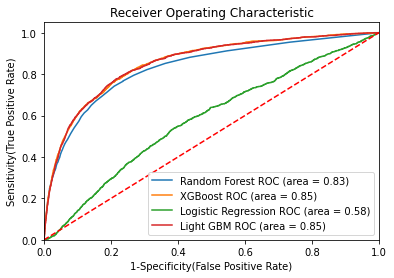

In [ ]:
plot_multiplt_rocauc(models,df_train,y_train, df_test, y_test)

* We will be going with the * **Light GBM** model as it is performing better than the other models

In [ ]:
model_lgb = LGBMClassifier(colsample_bytree=0.65, max_depth=4, min_data_in_leaf=400, min_split_gain=0.25, num_leaves=70, random_state=42, reg_lambda=5, subsample=0.65, scale_pos_weight=10)

model_lgb.fit(df_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


LGBMClassifier(colsample_bytree=0.65, max_depth=4, min_data_in_leaf=400,
               min_split_gain=0.25, num_leaves=70, random_state=42,
               reg_lambda=5, scale_pos_weight=10, subsample=0.65)

In [ ]:
y_pred                 = model_lgb.predict(df_test)
df_test['predictions'] = y_pred

In [ ]:
predict_model_lgb = lambda x: model_lgb.predict_proba(x).astype(float)

### Feature Importance and Model Explaination using SHAP and LIME

* ** Why Interpretability in Machine Learning model is needed:**
    * **
    * Fairness - We might be interested in trends of the feature wrt to target variable.
    * Checking causality of features & Debugging models - We might be interested in what pattern among the features model is capturing.
    * Regulations -Sometimes regulatory bodies need answers taken on model inference

* Explaining the model performance using SHAP so that black box model can become transparent one.
* **We will be looking at the model transparency using SHAP at global level and LIME at a local level**
* **
* The collective SHAP values can show how much each predictor contributes, either positively or negatively, to the target variable. This is like the variable importance plot but it is able to show the positive or negative relationship for each variable with the target .
    

* **SHAP(SHapely Additive exPlainations)**

#### Variable Importance Plot — Global Interpretability

In [ ]:
# drop the predictions column here
df_test = df_test.drop(columns = ['predictions'])

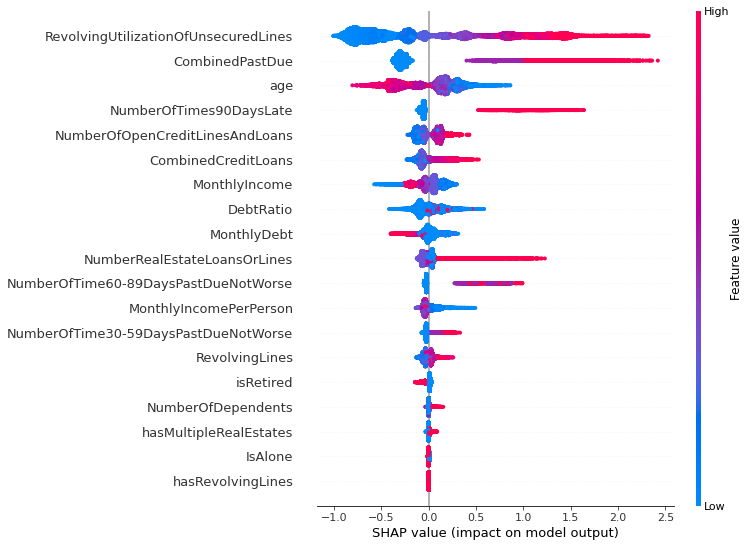

In [ ]:
X_importance = df_test

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(model_lgb)
shap_values = explainer.shap_values(X_importance)

# Plot summary_plot
shap.summary_plot(shap_values[1], X_importance)

* Feature importance: Variables are ranked in descending order.
* **
* Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.
* **
* Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.
* **
* Correlation: A high level of the “RevolvingUtilizationOfUnsecuredLines” and "Debt Ratio" has a high and positive impact on the defaulting. The “high” comes from the red color, and the “positive” impact is shown on the X-axis. Similarly, we will say the “age” is equally correlated with the target variable and non-target variable which might not give any good performance.
* "Monthly Income" effect is comparitvely low toward prediting values and even the effect is alos low

#### SHAP Dependence Plot — Global Interpretability

* The partial dependence plot shows the marginal effect one or two features have on the predicted outcome of a machine learning model. It tells whether the relationship between the target and a feature is linear, monotonic or more complex. 
* The function automatically includes another variable that your chosen variable interacts most with.

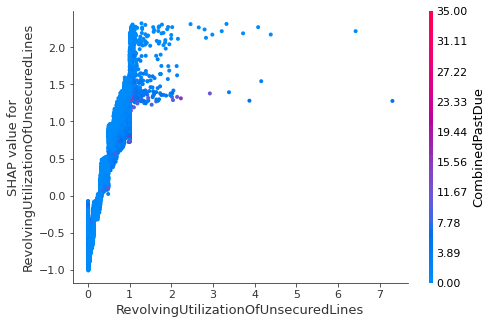

In [ ]:
shap.dependence_plot("RevolvingUtilizationOfUnsecuredLines", shap_values[1], X_importance)

* The following plot shows there is an very little linear and a bit of positive trend between “RevolvingUtilizationOfUnsecuredLines” and the target variable, and “RevolvingUtilizationOfUnsecuredLines” does not interact with “CombinedPastDue”.

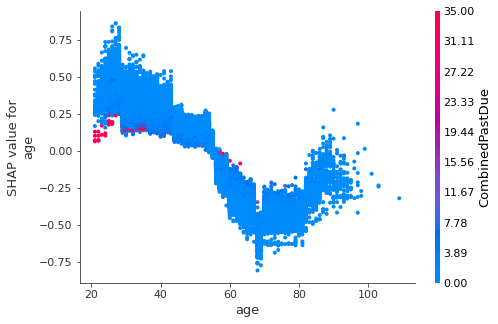

In [ ]:
shap.dependence_plot("age", shap_values[1], X_importance)

* The following plot shows there is an good linear and a negative trend between “age” and the target variable, and “age” interacts with “CombinedPastDue” not so much.

#### LIME(Local Interpretable Model agnostic Explanations)

* ** If we want to understand how a single prediction was made for a given observation. This is where we use the LIME technique which stands for local interpretable model agnostic explanations.**

* Generating explainations using LIME

In [ ]:
# creating the explainer function
explainer = LimeTabularExplainer(df_test.values, mode="classification", feature_names=df_test.columns)

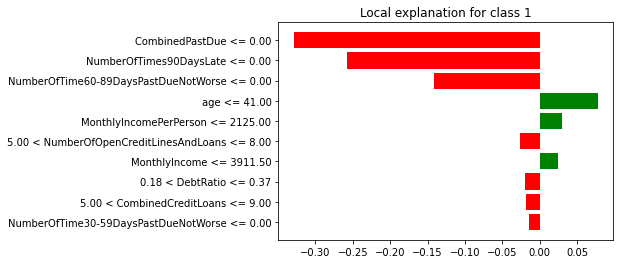

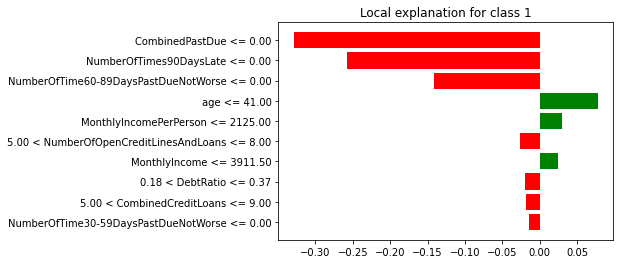

In [ ]:
exp = explainer.explain_instance(df_test.iloc[3], 
     predict_model_lgb, num_features=10)
exp.as_pyplot_figure()

* Green/Red color: features that have positive correlations with the target are shown in green, otherwise red.
* No of times 30-59, 59-90 days and 90 days past due having no values means not missed any due date showing veryr high negative correlation with the target
* age having less values lower than 41 relatively show positive corrrelation with the target

In [ ]:
# storing a new observation
i = 37
X_observation = df_test.iloc[[i], :]

# explanation using the random forest model
explanation = explainer.explain_instance(X_observation.values[0], predict_model_lgb)
explanation.show_in_notebook(show_table=True, show_all=False)
print(explanation.score)
        

0.7647504885620788


* Each feature’s contribution to this prediction is shown in the right bar plot. Orange signifies the positive impact and blue signifies the negative impact of that feature on the target. For example, CombinedPastDue has a positive impact on defaulting for this row.

In [ ]:
# storing a new observation
i = 25
X_observation = df_test.iloc[[i], :]

# explanation using the random forest model
explanation = explainer.explain_instance(X_observation.values[0], predict_model_lgb)
explanation.show_in_notebook(show_table=True, show_all=False)
print(explanation.score)

0.41990329670804205


* Each feature’s contribution to this prediction is shown in the right bar plot. Orange signifies the positive impact and blue signifies the negative impact of that feature on the target. For example, CombinedPastDue has a positive impact on non delinquency for this row which has value 0 and Monthly Income feature having value greater than 73000 contributing towards non delinquency.